# <center> 14MBID .- Trabajo de Fin de Master <center>
## <center> Desarrollo de un modelo predictivo en base a sintomatología de salud mental que derivan en ansiedad y depresión <center>
###   <center> (Primera Parte .- Analisis de Variables del año 2020) <center>
### <center> Autor: Ricardo Marrero Carrión <center>

### Indice
<ol>
<li>Librerias a Utilizar y Comprobaciones Iniciales</li>
<li>Funciones del modelo</li>
<li>Introducción</li>
<li>Carga de los Datasets</li>
<li>Limpieza y Preprocesamiento de los Datos I</li>
<li>Limpieza y Preprocesamiento de los Datos II</li>
<li>Limpieza y Preprocesamiento de los Datos III</li> 
<li>Reducción de los datos</li>
<li>Conjunto de Datos para el Análisis Exploratorio</li>
</ol>

### 1.- Librerías a Utilizar y comprobaciones iniciales

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib
plt.style.use('ggplot')
from matplotlib.pyplot import figure

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12,8)

import warnings
warnings.filterwarnings('ignore')

import missingno as ms

import utilidades as ut

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer

from feature_selector import FeatureSelector

### 2.- Funciones del Modelo

Las funciones utilizadas en el modelo, son importadas de un fichero .py llamado utilidades.py

### 3.- Introducción

_(Comprensión del Dominio)_

<b>Objetivo:</b> El objetivo del presente proyecto es identificar patrones dentro de un grupo de indicadores o atributos, y su posible relación con la Ansiedad y la Depresión.

<b>Datos:</b> El Conjunto de Datos utilizado en este proyecto se ha recogido en el Instituto Nacional de Estadística (INE), y específicamente en el resultado de la "Encuesta Europea de Salud 2020" [EESE-2020](https://www.ine.es/dyngs/INEbase/operacion.htm?c=Estadistica_C&cid=1254736176784&menu=resultados&idp=1254735573175#!tabs-1254736195298)

Esta encuesta genera dos conjuntos de datos según la fase de la entrevista:
* _Cuestionario del Hogar_: contiene datos generales de la entrevista y permite seleccionar al individuo para desarrolar la encuesta.
* _Cuestionario del Individio_: contiene los datos específicos de la entrevista, y se cumplimentan todos los indicadores sociodemográficos y de salud objeto de la entrevista.

<b>Enfoque:</b> Para ambos cuestionarios se genera un fichero con el diseño de registro de los microdatos; es decir, nos permite identificar a cada variable, su posición y longitud en el conjunto de datos, así como los posible valores que puede tomar cada atributo.

Estos ficheros son: dr_EESEhogar_2020 y dr_EESEadulto_2020

<b>Metodología:</b> La forma en que el conjunto de datos será procesado, seguirá lo indicado en la fases del _Proceso KDD_; donde:
* En una primera iteración sea realizará un estudio de cada grupo de datos, para identificar su comportamiento, y así poder realizar una limpieza y homogeneización de los mismos.
* Posteriormente se realizará un proceso de transformación donde se escojan los indicadores significativos para eñ desarrollo del modelo
* Por último se realizará un análisis exploratorio y de minería de datos, para identificar correlaciones y escoger el/los modelos que mejor se adapten al objetivo planteado

### 4.- Carga de los Datasets

_(Creación del Conjunto de Datos)_

In [2]:
#Insertar comentario del dataset
adulto2020 = pd.read_csv('datos_adulto_2020.csv', sep='\s+')

In [3]:
#Insertar comentario del dataset
hogar2020 = pd.read_csv('datos_hogar_2020.csv', sep='\s+')

Realizamos una inspección de ambos dataframes

In [4]:
adulto2020.head()

,CCAA,IDENTHOGAR,A7_2a,SEXOa,EDADa,PROXY_0,PROXY_1,PROXY_2,PROXY_2b,PROXY_3b,...,Y134,Y135,FACTORADULTO,CLASE_PR,IMC,CMD1,CMD2,CMD3,SEVERIDAD_DEPRESIVA,CUADROS_DEPRESIVOS
0,16,2500011,1,1,60,1,,,,,...,,,822.756,5,2,0.00,0.0,0.00,1,3
1,16,2500021,1,2,87,1,,,,,...,,,1287.294,1,9,0.00,0.0,0.00,3,3
2,16,2500031,1,1,38,1,,,,,...,,,607.022,4,3,2.86,0.0,6.67,3,2
3,16,2500061,2,2,43,1,,,,,...,1,3,1303.950,1,2,5.71,5.0,6.67,1,3
4,16,2500071,1,1,41,1,,,,,...,,,1341.778,4,3,0.00,0.0,0.00,1,3


In [5]:
hogar2020.head()

,CCAA,IDENTHOGAR,ESTRATO,SEXO_i,EDAD_i,NORDEN_Ai,NORDEN_Mi,NADULTOS,NMENORES,A7_1_i,...,D23_4,D23_5,D23_6,D23_7,D23_8,D23_9,D23_10,D23_11,D24,D26
0,16,2500011,6,1,60,01,,2,0,1,...,2,2,2,2,2,2,2,2,,99
1,16,2500011,6,2,59,02,,2,0,2,...,,,,,,,,,,99
2,16,2500021,6,2,87,01,,2,0,1,...,2,2,2,2,2,2,2,2,3,99
3,16,2500021,6,1,55,02,,2,0,2,...,,,,,,,,,,99
4,16,2500031,6,1,38,01,,1,0,1,...,2,2,2,2,2,2,2,2,,2


### 5.- Limpieza y Preprocesamiento de los Datos I

Para facilitar el análisis vamos a eliminar las columna o atributos de la Encuesta de Salud, que se considera no tienen relación en el modelo que se desea generar.

Principalmente son datos de codificación de la encuesta,o datos que pueden ser sustentados por otras preguntas de la encuesta.

Entre los dos datasets a utilzar hay __473 atributos__

In [6]:
print(adulto2020.shape)
print(hogar2020.shape)

(22072, 427)
(53329, 46)


In [7]:
#Listado de atributos a eliminar en el dataframe hogar2020
drop_hogar = ['NORDEN_Ai','NORDEN_Mi','NADULTOS','NMENORES','A7_1_i','NORDEN_Pref','A7_2','A8_1_i','A8_2_i',
              'NORINF','A9_otra','D24','CLASE_PR']

In [8]:
#Listado de atributos a eliminar en el dataframe adulto2020
drop_adulto = ['A7_2a','PROXY_0','PROXY_1','PROXY_2','PROXY_2b','PROXY_3b','PROXY_4','PROXY_5','E1C','E1E','W128Cer',
              'W128Cer_1','W128Cer_2','W128Cer_3','W128Cer_4','W128Cer_5','W128Cer_6','W128Cer_7','W128Vin',
              'W128Vin_1','W128Vin_2','W128Vin_3','W128Vin_4','W128Vin_5','W128Vin_6','W128Vin_7','W128Vermut',
              'W128Vermut_1','W128Vermut_2','W128Vermut_3','W128Vermut_4','W128Vermut_5','W128Vermut_6',
              'W128Vermut_7','W128Lic','W128Lic_1','W128Lic_2','W128Lic_3','W128Lic_4','W128Lic_5','W128Lic_6',
              'W128Lic_7','W128Comb','W128Comb_1','W128Comb_2','W128Comb_3','W128Comb_4','W128Comb_5','W128Comb_6',
              'W128Comb_7','W128Sidra','W128Sidra_1','W128Sidra_2','W128Sidra_3','W128Sidra_4','W128Sidra_5',
              'W128Sidra_6','W128Sidra_7','CMD1','CMD2','CMD3','N63_1','N63_2','N63_3','N63_4','N63_5','N63_6',
              'N63_7','N63_8','N63_9','N63_10','N64','N65_1','N65_2','N65_3','N65_4','N65_5','N65_6','N65_7',
               'N65_8']

In [9]:
hogar2020.drop(drop_hogar,axis='columns',inplace=True)
adulto2020.drop(drop_adulto,axis='columns',inplace=True)

En este mismo sentido, se detectan atributos duplicados entre ambas encuestas, por lo que procedemos a borrar una de ellas

In [10]:
drop_hogar2 = ['CCAA','SEXO_i','EDAD_i','A10_i']
hogar2020.drop(drop_hogar2,axis='columns',inplace=True)

In [11]:
print(adulto2020.shape)
print(hogar2020.shape)

(22072, 347)
(53329, 29)


Se han descartado 95 atributos, aún así; no es muy eficiente su tratamiento, por lo que vamos a analizarlo, mediante subsets dependiendo del módulo de la encuesta.

#### 5.1 - Encuesta del Hogar

En primer lugar vamos a seleccionar un atributo indice para identificar a cada registro, para ello utilizaremos el valor de IDENTHOGAR.

En el caso del dataset hogar, este atributo esta duplicado, si en el hogar habían varias personas; pero como solo uno contesta a la encuesta, podremos dejar un solo registro por hogar

In [12]:
hogar2020.sort_values('D23_1',ascending=False,inplace=True)
hogar2020.drop_duplicates('IDENTHOGAR',keep='first',inplace=True)
hogar2020 = hogar2020.set_index('IDENTHOGAR')
hogar2020.sort_values('IDENTHOGAR',inplace=True)

#### 5.2 - Encuesta del Individuo

Igualmente usaremos el atributo IDENTHOGAR como índice del Dataframe; en este caso si existen registros únicos

In [13]:
adulto2020 = adulto2020.set_index('IDENTHOGAR')
adulto2020.sort_values('IDENTHOGAR',inplace=True)

In [14]:
print(adulto2020.shape)
print(hogar2020.shape)

(22072, 346)
(22072, 28)


Y realizamos una primera exportación del dataset; como punto de control para pasar ahora a un segundo nivel de análisis en detalle

In [15]:
adulto2020.to_csv(r'adulto2020_1.csv')
hogar2020.to_csv(r'hogar2020_1.csv')

### 6.- Limpieza y Preprocesamiento de los Datos II

#### 6.1 - Encuesta del Hogar

Cada dataset tiene un enorme número de tributos, para realizar un análisis detallado de sus componentes; vamos a crear una serie de subsets dependiendo de area de conocimiento y según el fichero del diseño de regsitro de los microdatos

In [16]:
#Datos generales del hogar del encuestado
hogar2020_general = hogar2020[['ESTRATO','A11_i','A12','FACTORHOGAR']]

In [17]:
#Datos laborales del encuestado
hogar_2020_datos_persona = hogar2020[['B13','B14','B15_2','B16_2','B17','B18','B19a_2','B19b_2','B20a_2','B20b_2',
                                      'B21a','B21b']]

In [18]:
#Datos de tipo de ingresos del encuestado
hogar_2020_datos_ingresos = hogar2020[['D23_1','D23_2','D23_3','D23_4','D23_5','D23_6','D23_7','D23_8','D23_9',
                                       'D23_10','D23_11','D26']]

Para el subset hogar2020_general, no realizamos ninguna transformación

##### 6.1.1- Subset Datos Personas

In [19]:
#El tipo de los datos ha sido cargado en pandas como "object", por lo que hacemos un casting a enteros
hogar_2020_datos_persona.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22072 entries, 2500011 to 4996151
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   B13     22072 non-null  object
 1   B14     22072 non-null  object
 2   B15_2   22072 non-null  object
 3   B16_2   22072 non-null  object
 4   B17     22072 non-null  object
 5   B18     22072 non-null  object
 6   B19a_2  22072 non-null  object
 7   B19b_2  22072 non-null  object
 8   B20a_2  22072 non-null  object
 9   B20b_2  22072 non-null  object
 10  B21a    22072 non-null  object
 11  B21b    22072 non-null  object
dtypes: object(12)
memory usage: 2.2+ MB


In [20]:
for col in hogar_2020_datos_persona.columns:
    tipo_columna = hogar_2020_datos_persona[col].dtype
    if tipo_columna == 'O':
        hogar_2020_datos_persona[col] = pd.to_numeric(hogar_2020_datos_persona[col],
                                                            errors='coerce').astype('Int64')

In [21]:
for col in hogar_2020_datos_persona.columns:
    pct_missing = np.mean(hogar_2020_datos_persona[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

B13 - 88%
B14 - 100%
B15_2 - 99%
B16_2 - 99%
B17 - 99%
B18 - 97%
B19a_2 - 78%
B19b_2 - 86%
B20a_2 - 78%
B20b_2 - 86%
B21a - 78%
B21b - 86%


Se observa que estos atributos tienen un alto porcentaje de missing_values; es decir, no fueron contestados por los encuestados. Por lo que descartamos su uso.

Atributos similares, se encuentran en la encuesta individual

##### 6.1.2 - Subset Datos Ingresos

In [22]:
hogar_2020_datos_ingresos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22072 entries, 2500011 to 4996151
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   D23_1   22072 non-null  object
 1   D23_2   22072 non-null  object
 2   D23_3   22072 non-null  object
 3   D23_4   22072 non-null  object
 4   D23_5   22072 non-null  object
 5   D23_6   22072 non-null  object
 6   D23_7   22072 non-null  object
 7   D23_8   22072 non-null  object
 8   D23_9   22072 non-null  object
 9   D23_10  22072 non-null  object
 10  D23_11  22072 non-null  object
 11  D26     22072 non-null  int64 
dtypes: int64(1), object(11)
memory usage: 2.2+ MB


In [23]:
for col in hogar_2020_datos_ingresos.columns:
    tipo_columna = hogar_2020_datos_ingresos[col].dtype
    if tipo_columna == 'O':
        hogar_2020_datos_ingresos[col] = pd.to_numeric(hogar_2020_datos_ingresos[col],
                                                            errors='coerce').astype('Int64')

In [24]:
for col in hogar_2020_datos_ingresos.columns:
    pct_missing = np.mean(hogar_2020_datos_ingresos[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

D23_1 - 0%
D23_2 - 0%
D23_3 - 0%
D23_4 - 0%
D23_5 - 0%
D23_6 - 0%
D23_7 - 0%
D23_8 - 0%
D23_9 - 0%
D23_10 - 0%
D23_11 - 0%
D26 - 0%


En este caso hay ausencia de valores nulos

Cada uno de estos atributos representa un tipo de ingreso del encuestado; por lo que no eliminamos ni transformamos ninguna de las variables.

Por lo tanto los atributos a utilizar de la encuesta de hogar seran los siguientes:

In [25]:
df_hogar = pd.concat([hogar2020_general,hogar_2020_datos_ingresos],axis=1)

In [26]:
df_hogar.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22072 entries, 2500011 to 4996151
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ESTRATO      22072 non-null  int64  
 1   A11_i        22072 non-null  int64  
 2   A12          22072 non-null  int64  
 3   FACTORHOGAR  22072 non-null  float64
 4   D23_1        22072 non-null  Int64  
 5   D23_2        22072 non-null  Int64  
 6   D23_3        22072 non-null  Int64  
 7   D23_4        22072 non-null  Int64  
 8   D23_5        22072 non-null  Int64  
 9   D23_6        22072 non-null  Int64  
 10  D23_7        22072 non-null  Int64  
 11  D23_8        22072 non-null  Int64  
 12  D23_9        22072 non-null  Int64  
 13  D23_10       22072 non-null  Int64  
 14  D23_11       22072 non-null  Int64  
 15  D26          22072 non-null  int64  
dtypes: Int64(11), float64(1), int64(4)
memory usage: 3.1 MB


#### 6.2 - Encuesta del Individuo

Tal y como se realizó con el dataset del hogar, procedemos a subdividir según área de conocimiento y siguiendo el fichero de registro de los microdatos, para un mesjor análisis

In [27]:
#Datos asociados con el objetivo del estudio (ansiedad y depresión)
adulto2020_target = adulto2020[['G25a_20','G25b_20','G25c_20','G25a_21','G25b_21','G25c_21','SEVERIDAD_DEPRESIVA',
                            'CUADROS_DEPRESIVOS']]

In [28]:
#Datos generales del individuo encuestado
adulto2020_general = adulto2020[['CCAA','SEXOa','EDADa','E1_1','E2_1a','E2_1b','E2_1c','E2_1d','E3','E4',
                                 'E4b','ESTUDIOS','S109','S110','FACTORADULTO','CLASE_PR','IMC']]

In [29]:
#Datos Socioeconomicos
adulto2020_socioeconomico = adulto2020[['F6','F7','F8_2','F9_2','F10','F11','F12','F13','F14a','F14b','F15','F16',
                                        'F17','F18a_2','F18b_2','F19a_2','F19b_2','F20','J30','J31']]

In [30]:
#Datos Determinantes de la Salud
adulto2020_DeterminantesSalud = adulto2020[['R106','R107','R108_1','R108_2','R108_3','R108_4','T111','T112',
                                      'T113','T114','T115','T116','T117','T118_1','T118_2','T119','T119b_1',
                                      'T119b_2','U120_1','U120_1a','U120_2','U120_3','U120_4','U120_5','U120_6',
                                      'U120_7','U120_7a','U120_8','U120_9','U120_10','U120_11','U120_12','U120_13',
                                      'U120_14','U120_15','U120_15a','U120FZ','U120CANTFZ','V121','V123','V124',
                                      'V124a','V124b','V126','V126a','V126b','V126c','W127','W129','X130','X131',
                                      'X132','Y133','Y134','Y135']]

In [31]:
#Datos del Estado de la Salud del Individuo
adulto2020_EstadoSalud = adulto2020[['G21','G22','G23','G24','G24a','G25a_1','G25b_1','G25c_1','G25a_2','G25b_2',
                                     'G25c_2','G25d_2','G25a_3','G25b_3','G25c_3','G25a_4','G25b_4','G25c_4',
                                     'G25a_5','G25b_5','G25c_5','G25a_6','G25b_6','G25c_6','G25a_7','G25b_7',
                                     'G25c_7','G25a_8','G25b_8','G25c_8','G25a_9','G25b_9','G25c_9','G25a_10',
                                     'G25b_10','G25c_10','G25a_11','G25b_11','G25c_11','G25a_12','G25b_12',
                                     'G25c_12','G25a_13','G25b_13','G25c_13','G25a_14','G25b_14','G25c_14',
                                     'G25a_15','G25b_15','G25c_15','G25a_16','G25b_16','G25c_16','G25a_17',
                                     'G25b_17','G25c_17','G25a_18','G25b_18','G25c_18','G25a_19','G25b_19',
                                     'G25c_19','G25a_22','G25b_22','G25c_22','G25a_23','G25b_23','G25c_23',
                                     'G25d_23','G25a_24','G25b_24','G25c_24','G25a_25','G25b_25','G25c_25',
                                     'G25a_26','G25b_26','G25c_26','G25a_27','G25b_27','G25c_27','G25a_28',
                                     'G25b_28','G25c_28','G25a_29','G25b_29','G25c_29','G25a_30','G25b_30',
                                     'G25c_30','G25a_31','G25b_31','G25c_31','G25a_32','G25b_32','G25c_32',
                                     'H26_1','H26_2','H26_3','H27','K32','K33','K34','K35','K36','K37','K38',
                                     'K38a','K38b','L39_1','L39_2','L39_3','L39_4','L39_5','L40','L41','L42_1',
                                     'L42_2','L42_3','L42_4','L42_5','L42_6','L42_7','L43','L44','L45','L46']]

In [32]:
#Datos sobre la Asistencia Sanitaria
adulto2020_AsistenciaSanitaria = adulto2020[['N48','N49','N50','N51','N52','N53','N54','N57','N58_1','N58_2',
                                             'N58_3','N59','N60_1','N60_2','N60_3','N60_4','N60a_1','N60a_2',
                                             'N60a_3','N60a_4','N61_1','N61_2','N61_3','N61_4','N61_5','N62',
                                             'N62b','O66','O67','O68','O69','O71','O74','O75','O76','O78','O79',
                                             'O80_1','O80_2','O80_3','O81_1','O81_2','O81_3','O82_1','O82_2','O83',
                                             'O84_1','O84_2','O84_3','O84_4','O84_5','O84_6','O84_7','O84_8',
                                             'O84_9','P85','P86','P87_1a','P87_1b','P87_2a','P87_2b','P87_3a',
                                             'P87_3b','P87_4a','P87_4b','P87_5a','P87_5b','P87_6a','P87_6b',
                                             'P87_7a','P87_7b','P87_8a','P87_8b','P87_9a','P87_9b','P87_10a',
                                             'P87_10b','P87_11a','P87_11b','P87_12a','P87_12b','P87_13a',
                                             'P87_13b','P87_14a','P87_14b','P87_15a','P87_15b','P87_16a','P87_16b',
                                             'P87_17a','P87_17b','P87_18a','P87_18b','P87_19a','P87_19b','P87_20a',
                                             'P87_20b','P87_21a','P87_21b','P87_22a','P87_22b','P87_23a','P87_23b',
                                             'Q88','Q89','Q90','Q91','Q92','Q93','Q94','Q95','Q96','Q98','Q99',
                                             'Q100','Q101','Q103','Q104']]

##### 6.2.1 - Subset Target

In [33]:
adulto2020_target.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22072 entries, 2500011 to 4996151
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   G25a_20              22072 non-null  int64 
 1   G25b_20              22072 non-null  object
 2   G25c_20              22072 non-null  object
 3   G25a_21              22072 non-null  int64 
 4   G25b_21              22072 non-null  object
 5   G25c_21              22072 non-null  object
 6   SEVERIDAD_DEPRESIVA  22072 non-null  int64 
 7   CUADROS_DEPRESIVOS   22072 non-null  int64 
dtypes: int64(4), object(4)
memory usage: 1.5+ MB


El subset tiene 8 atributos, relacionados con haber haber padecido Ansiedad o Depresion.

Los atributos G25c_20 (Depresión) y G25c_21(Ansiedad), indican si han sido diagnosticados por un médico.

Usaremos estos entonces, como la CLASE del dataset

In [34]:
for col in adulto2020_target.columns:
    tipo_columna = adulto2020_target[col].dtype
    if tipo_columna == 'O':
        adulto2020_target[col] = pd.to_numeric(adulto2020_target[col],
                                                            errors='coerce').astype('Int64')

In [35]:
for col in adulto2020_target.columns:
    pct_missing = np.mean(adulto2020_target[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

G25a_20 - 0%
G25b_20 - 90%
G25c_20 - 90%
G25a_21 - 0%
G25b_21 - 92%
G25c_21 - 92%
SEVERIDAD_DEPRESIVA - 0%
CUADROS_DEPRESIVOS - 0%


Debemos cambiar los atributos TARGET, debido a que se oberva un alto porcentaje de missings en si las enfermedades han sido diagnosticadas por un médico.

Por lo tanto cambiamos nuestros valores TARGET a: G25a_20 (Depresión) y G25a_21(Ansiedad)

Que por cierto, no hay valores missing en dichas respuestas

Cambiamos el nombre de dichas columnas, para ir identificando nuestro target, y hacemos un nuevo subset que añadiremos al finel del dataframe final.

In [36]:
df_clase = adulto2020_target[['G25a_20','G25a_21']]
df_clase.columns = ['DEPRESION','ANSIEDAD']

In [37]:
#Funciones creadas en utilidades.py
ut.val_counts(df_clase)

DEPRESION value counts 



2    19931
1     2115
9       14
8       12
Name: DEPRESION, dtype: int64

************************************
ANSIEDAD value counts 



2    20248
1     1793
9       16
8       15
Name: ANSIEDAD, dtype: int64

************************************


Se observa que hay un pequeño número de registros que toman los valores de NO SABE (8) o NO CONTESTA (9).

Como representan un porcentaje muy bajo sobre el total de registros, se procede a agruparlos con la no presencia de la enfermedad (2), para no alterar la muestra de SI presencia de la enfermedad.

In [38]:
target_col = ['DEPRESION','ANSIEDAD']

In [39]:
for col in target_col:
    df_clase[col].replace({8 : 2, 
                           9 : 2},inplace=True)

Seguiremos usando los atributos G25b_x, ya que nos ayudarána. determinar si dichas enfermedades han estado presente en los últimos 12 meses; igualmente seguiremos usando por ahora, las variables derivadas SEVERIDAD_DEPRESIVA y CUADROS_DEPRESIVOS.

Igualmente con los atributos G25c_x; ya que en caso de haber presentado la enfermedad, nos dirá si fue diagnosticada por un medico

In [40]:
df_otros_clase = adulto2020_target[['G25b_20','G25c_20','G25b_21','G25c_21','SEVERIDAD_DEPRESIVA',
                                    'CUADROS_DEPRESIVOS']]

##### 6.2.2 - Subset General

In [41]:
adulto2020_general.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22072 entries, 2500011 to 4996151
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   CCAA          22072 non-null  int64  
 1   SEXOa         22072 non-null  int64  
 2   EDADa         22072 non-null  int64  
 3   E1_1          22072 non-null  int64  
 4   E2_1a         22072 non-null  int64  
 5   E2_1b         22072 non-null  int64  
 6   E2_1c         22072 non-null  int64  
 7   E2_1d         22072 non-null  int64  
 8   E3            2043 non-null   float64
 9   E4            22072 non-null  int64  
 10  E4b           22072 non-null  int64  
 11  ESTUDIOS      22072 non-null  int64  
 12  S109          22072 non-null  int64  
 13  S110          22072 non-null  int64  
 14  FACTORADULTO  22072 non-null  float64
 15  CLASE_PR      22072 non-null  int64  
 16  IMC           22072 non-null  int64  
dtypes: float64(2), int64(15)
memory usage: 3.0 MB


In [42]:
for col in adulto2020_general.columns:
    pct_missing = np.mean(adulto2020_general[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

CCAA - 0%
SEXOa - 0%
EDADa - 0%
E1_1 - 0%
E2_1a - 0%
E2_1b - 0%
E2_1c - 0%
E2_1d - 0%
E3 - 91%
E4 - 0%
E4b - 0%
ESTUDIOS - 0%
S109 - 0%
S110 - 0%
FACTORADULTO - 0%
CLASE_PR - 0%
IMC - 0%


In [43]:
#Funciones creadas en utilidades.py
ut.val_counts(adulto2020_general)

CCAA value counts 



1     2820
13    2327
9     2138
10    1870
12    1304
16    1229
8     1146
5     1138
7     1124
14    1007
3      979
6      929
11     923
2      821
15     747
17     648
4      396
19     294
18     232
Name: CCAA, dtype: int64

************************************
SEXOa value counts 



2    11682
1    10390
Name: SEXOa, dtype: int64

************************************
EDADa value counts 



43     457
44     438
60     428
56     426
42     425
      ... 
99       2
102      2
100      2
104      1
101      1
Name: EDADa, Length: 90, dtype: int64

************************************
E1_1 value counts 



1    20029
2     2043
Name: E1_1, dtype: int64

************************************
E2_1a value counts 



1    20758
2     1314
Name: E2_1a, dtype: int64

************************************
E2_1b value counts 



2    20196
1     1876
Name: E2_1b, dtype: int64

************************************
E2_1c value counts 



2    22071
1        1
Name: E2_1c, dtype: int64

************************************
E2_1d value counts 



2    22072
Name: E2_1d, dtype: int64

************************************
E3 value counts 



NaN     20029
20.0      159
15.0      144
13.0      135
14.0      120
        ...  
88.0        1
67.0        1
71.0        1
89.0        1
70.0        1
Name: E3, Length: 76, dtype: int64

************************************
E4 value counts 



3    10811
1    10703
2      401
9      148
8        9
Name: E4, dtype: int64

************************************
E4b value counts 



2    11301
1     5977
3     2896
5     1183
4      650
9       63
8        2
Name: E4b, dtype: int64

************************************
ESTUDIOS value counts 



5    5322
9    4277
4    4134
6    2800
3    1996
8    1848
7    1503
2     192
Name: ESTUDIOS, dtype: int64

************************************
S109 value counts 



160    1839
170    1803
165    1745
168    1011
175     965
       ... 
130       1
125       1
135       1
142       1
131       1
Name: S109, Length: 74, dtype: int64

************************************
S110 value counts 



70     1319
80     1248
75      974
65      971
60      883
       ... 
137       1
162       1
150       1
119       1
168       1
Name: S110, Length: 106, dtype: int64

************************************
FACTORADULTO value counts 



990.700     74
1967.462    52
915.296     51
2337.146    49
272.703     34
            ..
2758.487     1
5139.643     1
1314.381     1
2016.950     1
594.449      1
Name: FACTORADULTO, Length: 9593, dtype: int64

************************************
CLASE_PR value counts 



5    6934
3    4228
4    3048
6    2886
1    2301
2    1679
9     996
Name: CLASE_PR, dtype: int64

************************************
IMC value counts 



2    8964
3    8156
4    3379
9    1166
1     407
Name: IMC, dtype: int64

************************************


Del análisis de valores missing y tendencia en las respuestas, podemos descartar los siguientes atributos:
* E3 -> 91% de Missing Values
* E2_1c -> Tiene una sola tendencia de respuesta (NO)
* E2_1d -> Tiene una sola tendencia de respuesta (NO)

Por lo tanto, el subset de caracteristicas generales, queda de la siguiente forma:

In [44]:
df_generales = adulto2020_general[['CCAA','SEXOa','EDADa','E1_1','E2_1a','E2_1b','E4','E4b','ESTUDIOS',
                                   'S109','S110','FACTORADULTO','CLASE_PR','IMC']]

##### 6.2.3 - Subset Socioeconómico

In [45]:
adulto2020_socioeconomico.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22072 entries, 2500011 to 4996151
Data columns (total 20 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   F6      22072 non-null  object 
 1   F7      22072 non-null  object 
 2   F8_2    22072 non-null  object 
 3   F9_2    22072 non-null  object 
 4   F10     22072 non-null  object 
 5   F11     22072 non-null  object 
 6   F12     22072 non-null  object 
 7   F13     22072 non-null  object 
 8   F14a    22072 non-null  object 
 9   F14b    22072 non-null  object 
 10  F15     22072 non-null  object 
 11  F16     22072 non-null  object 
 12  F17     22072 non-null  object 
 13  F18a_2  22072 non-null  object 
 14  F18b_2  22072 non-null  object 
 15  F19a_2  22072 non-null  object 
 16  F19b_2  22072 non-null  object 
 17  F20     22072 non-null  object 
 18  J30     22072 non-null  object 
 19  J31     2223 non-null   float64
dtypes: float64(1), object(19)
memory usage: 3.5+ MB


In [46]:
for col in adulto2020_socioeconomico.columns:
    tipo_columna = adulto2020_socioeconomico[col].dtype
    if tipo_columna == 'O':
        adulto2020_socioeconomico[col] = pd.to_numeric(adulto2020_socioeconomico[col],
                                                            errors='coerce').astype('Int64')

In [47]:
for col in adulto2020_socioeconomico.columns:
    pct_missing = np.mean(adulto2020_socioeconomico[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

F6 - 68%
F7 - 98%
F8_2 - 94%
F9_2 - 94%
F10 - 94%
F11 - 91%
F12 - 85%
F13 - 56%
F14a - 94%
F14b - 100%
F15 - 56%
F16 - 56%
F17 - 56%
F18a_2 - 56%
F18b_2 - 61%
F19a_2 - 56%
F19b_2 - 61%
F20 - 61%
J30 - 56%
J31 - 90%


Al igual que ocurrió en la encuesta del hogar (subset datos de actividad economica), existe un alto porcentaje de valores missing; por lo tanto, procedemos a descatar igualmente este nivel de detalle del estado laboral del encuestado, y dejamos como valor de referencia el atributo A11_i (Situación laboral actual) de la encuesta del hogar.

Pero mantenemos el atributo J30, por estudiar si el individuo ha estado de baja laboral al último año


Igualmente, a pesar que tiene aproximadamente al mitad de los registros no posee información de la actividad de la empresa y ocupación, seguiremos utilizando las variables F18a_2, F19a_2 y F20, por si en una correlación futura hay relación con la presencia de deprsión o ansiedad

In [48]:
df_economico = adulto2020_socioeconomico[['F18a_2','F19a_2','F20','J30']]

##### 6.2.4 - Subset Determinantes de la Salud

In [49]:
adulto2020_DeterminantesSalud.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22072 entries, 2500011 to 4996151
Data columns (total 55 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   R106        22072 non-null  int64  
 1   R107        22072 non-null  int64  
 2   R108_1      22072 non-null  int64  
 3   R108_2      22072 non-null  int64  
 4   R108_3      22072 non-null  int64  
 5   R108_4      22072 non-null  int64  
 6   T111        22072 non-null  int64  
 7   T112        22072 non-null  int64  
 8   T113        22072 non-null  int64  
 9   T114        22072 non-null  object 
 10  T115        22072 non-null  int64  
 11  T116        22072 non-null  object 
 12  T117        22072 non-null  int64  
 13  T118_1      10294 non-null  float64
 14  T118_2      10294 non-null  float64
 15  T119        22072 non-null  int64  
 16  T119b_1     22072 non-null  int64  
 17  T119b_2     22072 non-null  int64  
 18  U120_1      22072 non-null  int64  
 19  U120_1a     15510

In [50]:
for col in adulto2020_DeterminantesSalud.columns:
    tipo_columna = adulto2020_DeterminantesSalud[col].dtype
    if tipo_columna == 'O':
        adulto2020_DeterminantesSalud[col] = pd.to_numeric(adulto2020_DeterminantesSalud[col],
                                                            errors='coerce').astype('Int64')

In [51]:
for col in adulto2020_DeterminantesSalud.columns:
    pct_missing = np.mean(adulto2020_DeterminantesSalud[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

R106 - 0%
R107 - 0%
R108_1 - 0%
R108_2 - 0%
R108_3 - 0%
R108_4 - 0%
T111 - 0%
T112 - 0%
T113 - 0%
T114 - 14%
T115 - 0%
T116 - 93%
T117 - 0%
T118_1 - 53%
T118_2 - 53%
T119 - 0%
T119b_1 - 0%
T119b_2 - 0%
U120_1 - 0%
U120_1a - 30%
U120_2 - 0%
U120_3 - 0%
U120_4 - 0%
U120_5 - 0%
U120_6 - 0%
U120_7 - 0%
U120_7a - 56%
U120_8 - 0%
U120_9 - 0%
U120_10 - 0%
U120_11 - 0%
U120_12 - 0%
U120_13 - 0%
U120_14 - 0%
U120_15 - 0%
U120_15a - 90%
U120FZ - 99%
U120CANTFZ - 99%
V121 - 0%
V123 - 81%
V124 - 81%
V124a - 19%
V124b - 58%
V126 - 0%
V126a - 93%
V126b - 0%
V126c - 99%
W127 - 0%
W129 - 35%
X130 - 0%
X131 - 0%
X132 - 0%
Y133 - 0%
Y134 - 90%
Y135 - 90%


In [52]:
# las preguntas Rxxx, estan relacionadas con atención médica no cubierta, crearemos un nuevo atributo resumen
#donde se indique SI (1) o NO (2) el encuestado se a visto afectado por este supuesto
adulto2020_DeterminantesSalud['R_Sum'] = np.where((adulto2020_DeterminantesSalud['R106'] == 1) | 
                                                   (adulto2020_DeterminantesSalud['R107'] == 1) |
                                                   (adulto2020_DeterminantesSalud['R108_1'] == 1) |
                                                   (adulto2020_DeterminantesSalud['R108_2'] == 1) |
                                                   (adulto2020_DeterminantesSalud['R108_3'] == 1) |
                                                   (adulto2020_DeterminantesSalud['R108_4'] == 1),1,2)

In [53]:
#Eliminamos columnas sumarizadas
adulto2020_DeterminantesSalud.drop(['R106','R107','R108_1','R108_2','R108_3','R108_3','R108_4'],
                                   axis=1,inplace=True)

In [54]:
# En lo relacionado con la actividad física, vamos a quedarnos solo con los atributos que determinan, que tipo
#de actividad se hace en el trabajo, y con que frecuencia se hace actividad física en el tiempo libre
adulto2020_DeterminantesSalud.drop(['T113','T114','T115','T116','T117','T118_1','T118_2','T119','T119b_1',
                                    'T119b_2'],axis=1,inplace=True)

In [55]:
#Eliminamos columnas relacionadas con alimentacion que contiene y alto porcentaje de missing_values, o son
#irrelevantes por su contexto
adulto2020_DeterminantesSalud.drop(['U120_1a','U120_7a','U120_15a','U120FZ','U120CANTFZ'],axis=1,inplace=True)

In [56]:
# Unificamos mediante un promedio, los atributos relacionados con el consumo de fruta
adulto2020_DeterminantesSalud['U_fruta_Avg'] = (adulto2020_DeterminantesSalud.U120_1 +
adulto2020_DeterminantesSalud.U120_15)/2
adulto2020_DeterminantesSalud['U_fruta_Avg'] = adulto2020_DeterminantesSalud['U_fruta_Avg'].astype(int)
adulto2020_DeterminantesSalud.drop(['U120_1','U120_15'],axis=1,inplace=True)

In [57]:
# Realizamos la misma transformación para otras otras variables de consumo de alimentos
#Alimentos Ultraprocesados
adulto2020_DeterminantesSalud['U_NoFood_Avg'] = (adulto2020_DeterminantesSalud.U120_9 +
adulto2020_DeterminantesSalud.U120_11 + adulto2020_DeterminantesSalud.U120_12 +
adulto2020_DeterminantesSalud.U120_13 + adulto2020_DeterminantesSalud.U120_14)/5
adulto2020_DeterminantesSalud['U_NoFood_Avg'] = adulto2020_DeterminantesSalud['U_NoFood_Avg'].astype(int)
adulto2020_DeterminantesSalud.drop(['U120_9','U120_11','U120_12','U120_13','U120_14'],axis=1,inplace=True)

In [58]:
#Alimentos Huevos y Lacteos
adulto2020_DeterminantesSalud['U_HuLac_Avg'] = (adulto2020_DeterminantesSalud.U120_3 +
adulto2020_DeterminantesSalud.U120_10)/2
adulto2020_DeterminantesSalud['U_HuLac_Avg'] = adulto2020_DeterminantesSalud['U_HuLac_Avg'].astype(int)
adulto2020_DeterminantesSalud.drop(['U120_3','U120_10'],axis=1,inplace=True)

In [59]:
#Alimentos Carbohidratos
adulto2020_DeterminantesSalud['U_Carb_Avg'] = (adulto2020_DeterminantesSalud.U120_5 +
adulto2020_DeterminantesSalud.U120_6)/2
adulto2020_DeterminantesSalud['U_Carb_Avg'] = adulto2020_DeterminantesSalud['U_Carb_Avg'].astype(int)
adulto2020_DeterminantesSalud.drop(['U120_5','U120_6'],axis=1,inplace=True)

In [60]:
#Analisis sobre Consumo de Tabaco, solo nos aportaría información si fuma y su frecuencia, por lo que dejamos 
#solo la variable V121
adulto2020_DeterminantesSalud.drop(['V123','V124','V124a','V124b','V126','V126a','V126b','V126c'],
                                   axis=1,inplace=True)

In [61]:
#Analisis de consumo de alcohol, igualmente nos quedamos solo con la frecuencia de consumo W127
adulto2020_DeterminantesSalud.drop('W129',axis=1,inplace=True)

In [62]:
#Analisis de Apoyo Social y Cuidado de Personas
#Descartamos la variable Y134, porque en principio no aporta el parentesco de a quien se cuida.
#La variable Y135, posee un alto porcentaje de missing, pero aporta información de cuantas horas dedica el
#encuestado al cuidado; podemos completarlo con el valor por defecto "No Contesta (9)"
adulto2020_DeterminantesSalud.drop('Y134',axis=1,inplace=True)
adulto2020_DeterminantesSalud['Y135'] = adulto2020_DeterminantesSalud['Y135'].fillna(9)

In [63]:
adulto2020_DeterminantesSalud.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22072 entries, 2500011 to 4996151
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   T111          22072 non-null  int64
 1   T112          22072 non-null  int64
 2   U120_2        22072 non-null  int64
 3   U120_4        22072 non-null  int64
 4   U120_7        22072 non-null  int64
 5   U120_8        22072 non-null  int64
 6   V121          22072 non-null  int64
 7   W127          22072 non-null  int64
 8   X130          22072 non-null  int64
 9   X131          22072 non-null  int64
 10  X132          22072 non-null  int64
 11  Y133          22072 non-null  int64
 12  Y135          22072 non-null  Int64
 13  R_Sum         22072 non-null  int64
 14  U_fruta_Avg   22072 non-null  int64
 15  U_NoFood_Avg  22072 non-null  int64
 16  U_HuLac_Avg   22072 non-null  int64
 17  U_Carb_Avg    22072 non-null  int64
dtypes: Int64(1), int64(17)
memory usage: 3.2 MB


In [64]:
#Para estandarizar los df que luego seran concatentados en el dataset individuos
df_determinante = adulto2020_DeterminantesSalud

##### 6.2.5 - Subset Estado de Salud

In [65]:
adulto2020_EstadoSalud.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22072 entries, 2500011 to 4996151
Columns: 128 entries, G21 to L46
dtypes: int64(42), object(86)
memory usage: 21.7+ MB


De entrada vemos que como es un alto número de atributos, no observamos el detalle de cada uno de ellos.

Esta situación nos podría servier de partida para hacer un análisis de este dataset buscando reducir su dimensionalidad

In [66]:
for col in adulto2020_EstadoSalud.columns:
    tipo_columna = adulto2020_EstadoSalud[col].dtype
    if tipo_columna == 'O':
        adulto2020_EstadoSalud[col] = pd.to_numeric(adulto2020_EstadoSalud[col],errors='coerce').astype('Int64')

In [67]:
adulto2020_EstadoSalud.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22072 entries, 2500011 to 4996151
Columns: 128 entries, G21 to L46
dtypes: Int64(86), int64(42)
memory usage: 23.5 MB


In [68]:
for col in adulto2020_EstadoSalud.columns:
    pct_missing = np.mean(adulto2020_EstadoSalud[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

G21 - 0%
G22 - 0%
G23 - 0%
G24 - 72%
G24a - 0%
G25a_1 - 0%
G25b_1 - 72%
G25c_1 - 72%
G25a_2 - 0%
G25b_2 - 98%
G25c_2 - 98%
G25d_2 - 99%
G25a_3 - 0%
G25b_3 - 98%
G25c_3 - 98%
G25a_4 - 0%
G25b_4 - 93%
G25c_4 - 93%
G25a_5 - 0%
G25b_5 - 85%
G25c_5 - 85%
G25a_6 - 0%
G25b_6 - 79%
G25c_6 - 79%
G25a_7 - 0%
G25b_7 - 84%
G25c_7 - 84%
G25a_8 - 0%
G25b_8 - 81%
G25c_8 - 81%
G25a_9 - 0%
G25b_9 - 87%
G25c_9 - 87%
G25a_10 - 0%
G25b_10 - 95%
G25c_10 - 95%
G25a_11 - 0%
G25b_11 - 96%
G25c_11 - 96%
G25a_12 - 0%
G25b_12 - 90%
G25c_12 - 90%
G25a_13 - 0%
G25b_13 - 97%
G25c_13 - 97%
G25a_14 - 0%
G25b_14 - 95%
G25c_14 - 95%
G25a_15 - 0%
G25b_15 - 78%
G25c_15 - 78%
G25a_16 - 0%
G25b_16 - 87%
G25c_16 - 87%
G25a_17 - 0%
G25b_17 - 95%
G25c_17 - 95%
G25a_18 - 0%
G25b_18 - 96%
G25c_18 - 96%
G25a_19 - 0%
G25b_19 - 99%
G25c_19 - 99%
G25a_22 - 0%
G25b_22 - 98%
G25c_22 - 98%
G25a_23 - 0%
G25b_23 - 98%
G25c_23 - 98%
G25d_23 - 99%
G25a_24 - 0%
G25b_24 - 91%
G25c_24 - 91%
G25a_25 - 0%
G25b_25 - 93%
G25c_25 - 93%
G25a_26 - 

Al tener un gran numero de atributos, vamos a ir analizando por seccion

In [69]:
#Accidentalidad (Hx)
#Descartamos H27, porque es un detalle que no aporta en el analisis, y creamos una variable transformada
#agrupando los tipos de accidente
adulto2020_EstadoSalud['H_Sum'] = np.where((adulto2020_EstadoSalud['H26_1'] == 1) | 
                                                   (adulto2020_EstadoSalud['H26_2'] == 1) |
                                                   (adulto2020_EstadoSalud['H26_3'] == 1),1,2)
adulto2020_EstadoSalud.drop(['H26_1','H26_2','H26_3','H27'],axis=1,inplace=True)

In [70]:
#Limitaciones físicas y sensoriales
#Creamos igualmemte una variable transformada que agrupe la existencia de limitaciones físicas y sensoriales
# y mantenemos la variable K38a, que trata sobre la dificultad de concentrarse
adulto2020_EstadoSalud['K_Sum'] = np.where((adulto2020_EstadoSalud['K32'] == 1) | 
                                                   (adulto2020_EstadoSalud['K34'] == 1) |
                                                   (adulto2020_EstadoSalud['K37'] == 1) |
                                                   (adulto2020_EstadoSalud['K38'] == 1),1,2)
adulto2020_EstadoSalud.drop(['K32','K33','K33','K34','K35','K36','K37','K38','K38b'],axis=1,inplace=True)

In [71]:
#Limitaciones en la Actividad Diaria
#La mayoria de los atributos contienen un alto porcentaje de missings, en este punto solo eliminaremos los que
#consideramos que no aportan valor o con mas de 90% de missing values
adulto2020_EstadoSalud.drop(['L39_2','L40','L41','L43','L44'],axis=1,inplace=True)

A continuación analizaremos los atributos específicos relacionados con las enfermedades; la encuesta_individuo preguntó sobre 30 tipos distintos.

Para simplificar el estudio procedemos a:
* Borrar si fueron diagnosticadas los últimos 12 meses; es un indicador que solo nos interesa para el caso de la ansiedad y la depresión.
* Crear un atributo que indique si la enfermedad está presente y si fue diagnosticada por un médico

In [72]:
adulto2020_EstadoSalud.drop(['G25b_1','G25b_2','G25b_3','G25b_4','G25b_5','G25b_6','G25b_7','G25b_8','G25b_9',
                            'G25b_10','G25b_11','G25b_12','G25b_13','G25b_14','G25b_15','G25b_16','G25b_17',
                             'G25b_18','G25b_19','G25b_22','G25b_23','G25b_24','G25b_25','G25b_26','G25b_27',
                             'G25b_28','G25b_29','G25b_30','G25b_31','G25b_32','G25d_2','G25d_23']
                            ,axis=1,inplace=True)

In [73]:
diag_col = ['G25c_1','G25c_2','G25c_3','G25c_4','G25c_5','G25c_6','G25c_7','G25c_8','G25c_9','G25c_10','G25c_11',
            'G25c_12','G25c_13','G25c_14','G25c_15','G25c_16','G25c_17','G25c_18','G25c_19','G25c_22','G25c_23',
            'G25c_24','G25c_25','G25c_26','G25c_27','G25c_28','G25c_29','G25c_30','G25c_31','G25c_32']

In [74]:
# Se completan valores nulos con 0 ya que estos son generados cuando no se presenta la enfermedad encuestada
for col in diag_col:
    adulto2020_EstadoSalud[col].fillna(0, inplace=True)

In [75]:
enf_col = ['G25a_1','G25a_2','G25a_3','G25a_4','G25a_5','G25a_6','G25a_7','G25a_8','G25a_9','G25a_10','G25a_11',
            'G25a_12','G25a_13','G25a_14','G25a_15','G25a_16','G25a_17','G25a_18','G25a_19','G25a_22','G25a_23',
            'G25a_24','G25a_25','G25a_26','G25a_27','G25a_28','G25a_29','G25a_30','G25a_31','G25a_32']

In [76]:
#Enfermedades en la prostata y menopauisa, generan null_values según el genero del encuestado; sustituimos por 
#(2) no presenta la enfermedad
for col in enf_col:
    adulto2020_EstadoSalud[col].fillna(2, inplace=True)

Se procede a crear la variable transformada con estas condiciones:
* SI enfermedad & SI diagnosticada = Enfermedad Diagnosticada (1)
* SI enfermedad & NO diagnosticada = Enfermedad No Diagnosticada (3)
* SI enfermedad & NO sabe/NoContesta diagnosticada = Enfermedad No Diagnosticada (3)
* NO enfermedad = No enfermedad (2)

In [77]:
#Funciones creadas en utilidades.py
adulto2020_EstadoSalud['G25_1'] = adulto2020_EstadoSalud.apply(ut.tension_alta, axis=1)
adulto2020_EstadoSalud['G25_2'] = adulto2020_EstadoSalud.apply(ut.infarto, axis=1)
adulto2020_EstadoSalud['G25_3'] = adulto2020_EstadoSalud.apply(ut.angina, axis=1)
adulto2020_EstadoSalud['G25_4'] = adulto2020_EstadoSalud.apply(ut.otros_corazon, axis=1)
adulto2020_EstadoSalud['G25_5'] = adulto2020_EstadoSalud.apply(ut.varices, axis=1)
adulto2020_EstadoSalud['G25_6'] = adulto2020_EstadoSalud.apply(ut.artrosis, axis=1)
adulto2020_EstadoSalud['G25_7'] = adulto2020_EstadoSalud.apply(ut.cervical, axis=1)
adulto2020_EstadoSalud['G25_8'] = adulto2020_EstadoSalud.apply(ut.lumbar, axis=1)
adulto2020_EstadoSalud['G25_9'] = adulto2020_EstadoSalud.apply(ut.alergia, axis=1)
adulto2020_EstadoSalud['G25_10'] = adulto2020_EstadoSalud.apply(ut.asma, axis=1)
adulto2020_EstadoSalud['G25_11'] = adulto2020_EstadoSalud.apply(ut.bronquitis, axis=1)
adulto2020_EstadoSalud['G25_12'] = adulto2020_EstadoSalud.apply(ut.diabetes, axis=1)
adulto2020_EstadoSalud['G25_13'] = adulto2020_EstadoSalud.apply(ut.ulcera, axis=1)
adulto2020_EstadoSalud['G25_14'] = adulto2020_EstadoSalud.apply(ut.urinaria, axis=1)
adulto2020_EstadoSalud['G25_15'] = adulto2020_EstadoSalud.apply(ut.colesterol, axis=1)
adulto2020_EstadoSalud['G25_16'] = adulto2020_EstadoSalud.apply(ut.cataratas, axis=1)
adulto2020_EstadoSalud['G25_17'] = adulto2020_EstadoSalud.apply(ut.dermatitis, axis=1)
adulto2020_EstadoSalud['G25_18'] = adulto2020_EstadoSalud.apply(ut.estrenimiento, axis=1)
adulto2020_EstadoSalud['G25_19'] = adulto2020_EstadoSalud.apply(ut.cirrosis, axis=1)
adulto2020_EstadoSalud['G25_22'] = adulto2020_EstadoSalud.apply(ut.otros_mental, axis=1)
adulto2020_EstadoSalud['G25_23'] = adulto2020_EstadoSalud.apply(ut.ictus, axis=1)
adulto2020_EstadoSalud['G25_24'] = adulto2020_EstadoSalud.apply(ut.migrana, axis=1)
adulto2020_EstadoSalud['G25_25'] = adulto2020_EstadoSalud.apply(ut.hemorroides, axis=1)
adulto2020_EstadoSalud['G25_26'] = adulto2020_EstadoSalud.apply(ut.tumores, axis=1)
adulto2020_EstadoSalud['G25_27'] = adulto2020_EstadoSalud.apply(ut.osteoporosis, axis=1)
adulto2020_EstadoSalud['G25_28'] = adulto2020_EstadoSalud.apply(ut.tiroides, axis=1)
adulto2020_EstadoSalud['G25_29'] = adulto2020_EstadoSalud.apply(ut.rinon, axis=1)
adulto2020_EstadoSalud['G25_30'] = adulto2020_EstadoSalud.apply(ut.prostata, axis=1)
adulto2020_EstadoSalud['G25_31'] = adulto2020_EstadoSalud.apply(ut.meonopausia, axis=1)
adulto2020_EstadoSalud['G25_32'] = adulto2020_EstadoSalud.apply(ut.lesiones, axis=1)

In [78]:
adulto2020_EstadoSalud.drop(diag_col,axis=1,inplace=True)
adulto2020_EstadoSalud.drop(enf_col,axis=1,inplace=True)

In [79]:
adulto2020_EstadoSalud.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22072 entries, 2500011 to 4996151
Data columns (total 51 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   G21     22072 non-null  int64
 1   G22     22072 non-null  int64
 2   G23     22072 non-null  int64
 3   G24     6106 non-null   Int64
 4   G24a    22072 non-null  int64
 5   K38a    22072 non-null  int64
 6   L39_1   11102 non-null  Int64
 7   L39_3   11102 non-null  Int64
 8   L39_4   11102 non-null  Int64
 9   L39_5   11102 non-null  Int64
 10  L42_1   11102 non-null  Int64
 11  L42_2   11102 non-null  Int64
 12  L42_3   11102 non-null  Int64
 13  L42_4   11102 non-null  Int64
 14  L42_5   11102 non-null  Int64
 15  L42_6   11102 non-null  Int64
 16  L42_7   11102 non-null  Int64
 17  L45     22072 non-null  int64
 18  L46     22072 non-null  int64
 19  H_Sum   22072 non-null  int64
 20  K_Sum   22072 non-null  int64
 21  G25_1   22072 non-null  int64
 22  G25_2   22072 non-null  int64
 23  G25

In [80]:
#Para estandarizar los df que luego seran concatentados en el dataset individuos
df_estadosalud = adulto2020_EstadoSalud

##### 6.2.6 - Subset Asistencia Sanitaria

In [81]:
adulto2020_AsistenciaSanitaria.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22072 entries, 2500011 to 4996151
Columns: 118 entries, N48 to Q104
dtypes: float64(12), int64(39), object(67)
memory usage: 20.0+ MB


In [82]:
for col in adulto2020_AsistenciaSanitaria.columns:
    tipo_columna = adulto2020_AsistenciaSanitaria[col].dtype
    if tipo_columna == 'O':
        adulto2020_AsistenciaSanitaria[col] = pd.to_numeric(adulto2020_AsistenciaSanitaria[col],
                                                            errors='coerce').astype('Int64')

In [83]:
adulto2020_AsistenciaSanitaria.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22072 entries, 2500011 to 4996151
Columns: 118 entries, N48 to Q104
dtypes: Int64(67), float64(12), int64(39)
memory usage: 21.4 MB


In [84]:
#Los atributos 'float64', pueden ser tambien convertidos en enteros, ya que hacen referencia a atributos con
#valores discretos
for col in adulto2020_AsistenciaSanitaria.columns:
    tipo_columna = adulto2020_AsistenciaSanitaria[col].dtype
    if tipo_columna == 'float64':
        adulto2020_AsistenciaSanitaria[col] = pd.to_numeric(adulto2020_AsistenciaSanitaria[col],
                                                            errors='coerce').astype('Int64')

In [85]:
for col in adulto2020_AsistenciaSanitaria.columns:
    pct_missing = np.mean(adulto2020_AsistenciaSanitaria[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

N48 - 0%
N49 - 16%
N50 - 0%
N51 - 44%
N52 - 94%
N53 - 73%
N54 - 73%
N57 - 73%
N58_1 - 0%
N58_2 - 0%
N58_3 - 0%
N59 - 0%
N60_1 - 0%
N60_2 - 0%
N60_3 - 0%
N60_4 - 0%
N60a_1 - 0%
N60a_2 - 0%
N60a_3 - 0%
N60a_4 - 0%
N61_1 - 0%
N61_2 - 0%
N61_3 - 69%
N61_4 - 0%
N61_5 - 0%
N62 - 0%
N62b - 86%
O66 - 0%
O67 - 92%
O68 - 92%
O69 - 78%
O71 - 91%
O74 - 91%
O75 - 0%
O76 - 92%
O78 - 0%
O79 - 77%
O80_1 - 77%
O80_2 - 77%
O80_3 - 77%
O81_1 - 77%
O81_2 - 77%
O81_3 - 77%
O82_1 - 77%
O82_2 - 77%
O83 - 77%
O84_1 - 0%
O84_2 - 0%
O84_3 - 0%
O84_4 - 0%
O84_5 - 0%
O84_6 - 0%
O84_7 - 0%
O84_8 - 0%
O84_9 - 0%
P85 - 0%
P86 - 0%
P87_1a - 36%
P87_1b - 92%
P87_2a - 36%
P87_2b - 67%
P87_3a - 36%
P87_3b - 98%
P87_4a - 36%
P87_4b - 94%
P87_5a - 36%
P87_5b - 98%
P87_6a - 36%
P87_6b - 96%
P87_7a - 36%
P87_7b - 86%
P87_8a - 36%
P87_8b - 97%
P87_9a - 36%
P87_9b - 100%
P87_10a - 36%
P87_10b - 98%
P87_11a - 36%
P87_11b - 93%
P87_12a - 36%
P87_12b - 76%
P87_13a - 36%
P87_13b - 88%
P87_14a - 36%
P87_14b - 94%
P87_15a - 80%
P87

Al tener un gran numero de atributos, vamos a ir analizando por seccion

In [86]:
#Consultas Médicas
#Descartamos atributos que son son objeto del estudio de la depresión o la ansiedad
adulto2020_AsistenciaSanitaria.drop(['N52','N54','N58_1','N59','N60_1','N60_2','N60_3','N60_4','N60a_1',
                            'N60a_2','N60a_3','N60a_4','N61_3','N61_4','N61_5','N62','N62b'],axis=1,inplace=True)

In [87]:
#Para completar missing_values de los valores de esta sección, los completaremos con el valor de no contesta o
#que no ha realizado visitas al médico, según corresponda al atributo
adulto2020_AsistenciaSanitaria['N49'] = adulto2020_AsistenciaSanitaria['N49'].fillna(0)
adulto2020_AsistenciaSanitaria['N51'] = adulto2020_AsistenciaSanitaria['N51'].fillna(0)
adulto2020_AsistenciaSanitaria['N53'] = adulto2020_AsistenciaSanitaria['N53'].fillna(99)
adulto2020_AsistenciaSanitaria['N57'] = adulto2020_AsistenciaSanitaria['N57'].fillna(9)

In [88]:
#Hospitalizaciones
#Descartamos atributos que son son objeto del estudio de la depresióno la ansiedad
adulto2020_AsistenciaSanitaria.drop(['O69','O74','O80_1','O80_2','O80_3','O81_1','O81_2','O81_3','O82_1',
                            'O82_2'],axis=1,inplace=True)

In [89]:
#Para completar missing_values de los valores de esta sección, los completaremos con el valor de no contesta o
#que no ha realizado visitas al médico, según corresponda al atributo
adulto2020_AsistenciaSanitaria['O67'] = adulto2020_AsistenciaSanitaria['O67'].fillna(0)
adulto2020_AsistenciaSanitaria['O68'] = adulto2020_AsistenciaSanitaria['O68'].fillna(0)
adulto2020_AsistenciaSanitaria['O71'] = adulto2020_AsistenciaSanitaria['O71'].fillna(9)
adulto2020_AsistenciaSanitaria['O76'] = adulto2020_AsistenciaSanitaria['O76'].fillna(0)
adulto2020_AsistenciaSanitaria['O79'] = adulto2020_AsistenciaSanitaria['O79'].fillna(0)
adulto2020_AsistenciaSanitaria['O83'] = adulto2020_AsistenciaSanitaria['O83'].fillna(9)

In [90]:
#Consumo de Medicamentos
#Solo seguiremos utilizando los atributos que indican si esta consumiendo un medicamente;recetado o no
adulto2020_AsistenciaSanitaria.drop(['P85','P86','P87_1b','P87_2b','P87_3b','P87_4b','P87_5b','P87_6b','P87_7b',
                                     'P87_8b','P87_9b','P87_10b','P87_11b','P87_12b','P87_13b','P87_14b','P87_15b',
                                     'P87_16b','P87_17b','P87_18b','P87_19b','P87_20b','P87_21b','P87_22b',
                                     'P87_23b'],axis=1,inplace=True)

In [91]:
#Ahora creamos una columan sumarizada que indique el número de medicamentos que está consumiendo el individuo
consumo_col = ['P87_1a','P87_2a','P87_3a','P87_4a','P87_5a','P87_6a','P87_7a','P87_8a','P87_9a','P87_10a',
               'P87_11a','P87_12a','P87_13a','P87_14a','P87_15a','P87_16a','P87_17a','P87_18a','P87_19a','P87_20a',
               'P87_21a','P87_22a','P87_23a']

In [92]:
#Solo dejamos el valor 1 si esta consumiendo un medicamento
#Completamos valores nulos con 0
for col in consumo_col:
    adulto2020_AsistenciaSanitaria[col].replace({2 : 0, 
                                                 8 : 0, 
                                                 9 : 0}, 
                                                 inplace=True)
    adulto2020_AsistenciaSanitaria[col].fillna(0,inplace=True)

In [93]:
adulto2020_AsistenciaSanitaria['P_Sum'] = adulto2020_AsistenciaSanitaria[consumo_col].sum(axis=1).astype('Int64')

In [94]:
adulto2020_AsistenciaSanitaria.drop(consumo_col,axis=1,inplace=True)

In [95]:
#Practicas Preventivas
#Estros atributos no indican relación con el objeto de este estudio
adulto2020_AsistenciaSanitaria.drop(['Q88','Q89','Q90','Q91','Q92','Q93','Q94','Q95','Q96','Q98','Q99','Q100',
                                     'Q101','Q103','Q104'],axis=1,inplace=True)

In [96]:
df_AsistenciaSanitaria = adulto2020_AsistenciaSanitaria

In [97]:
#Una vez analizados los subsets del conjunto de datos del individuo, procedemos concaterlos en un df_individuo
df_individuo = pd.concat([df_generales,df_economico,df_determinante,df_estadosalud,df_AsistenciaSanitaria,
                         df_otros_clase,df_clase],axis=1)

Por último procedemos a crear el Dataset que será utilizado en la siguiente fase del proceso KDD, donde seleccionaremos las características significantes del modelo.

Para ello concatenamos los datasets resultantes de la limpieza y análisis de la encuesta_hogar y encuesta_individuo

Por ultimo, guardamos un .csv como punto de control

In [98]:
df_individuo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22072 entries, 2500011 to 4996151
Columns: 124 entries, CCAA to ANSIEDAD
dtypes: Int64(32), float64(1), int64(91)
memory usage: 21.7 MB


In [99]:
df_hogar.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22072 entries, 2500011 to 4996151
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ESTRATO      22072 non-null  int64  
 1   A11_i        22072 non-null  int64  
 2   A12          22072 non-null  int64  
 3   FACTORHOGAR  22072 non-null  float64
 4   D23_1        22072 non-null  Int64  
 5   D23_2        22072 non-null  Int64  
 6   D23_3        22072 non-null  Int64  
 7   D23_4        22072 non-null  Int64  
 8   D23_5        22072 non-null  Int64  
 9   D23_6        22072 non-null  Int64  
 10  D23_7        22072 non-null  Int64  
 11  D23_8        22072 non-null  Int64  
 12  D23_9        22072 non-null  Int64  
 13  D23_10       22072 non-null  Int64  
 14  D23_11       22072 non-null  Int64  
 15  D26          22072 non-null  int64  
dtypes: Int64(11), float64(1), int64(4)
memory usage: 3.1 MB


In [100]:
df_full = pd.concat([df_hogar,df_individuo],axis=1)

In [101]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22072 entries, 2500011 to 4996151
Columns: 140 entries, ESTRATO to ANSIEDAD
dtypes: Int64(43), float64(2), int64(95)
memory usage: 24.6 MB


En esta fase hemos reducido la cantidad de atributos de 473 indicadores a 142

In [102]:
df_full.to_csv('full2020_temp.csv')

### 7.- Limpieza y Preprocesamiento de los Datos III

Antes de proceder a la selección de los atributos significativos y el análisis exploratorio, se realiza una última inspección con el conjunto completo de datos

In [103]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22072 entries, 2500011 to 4996151
Columns: 140 entries, ESTRATO to ANSIEDAD
dtypes: Int64(43), float64(2), int64(95)
memory usage: 24.6 MB


Como se comentó anteriormente, se trata de un conjunto de datos de 142 variables, todas ellas numéricas discretas (int64) o numéricas continuas (float64)

Hay dos atributos que descartamos ya que son estimadores de razón, que aporta solo información en la calibración de la encuesta pero no con la ansiedad o la depresión

In [104]:
df_full.drop(['FACTORHOGAR','FACTORADULTO'],axis='columns',inplace=True)

Se realiza una nueva inspección para determinar si siguen apareciendo valores nulos

<AxesSubplot:ylabel='IDENTHOGAR'>

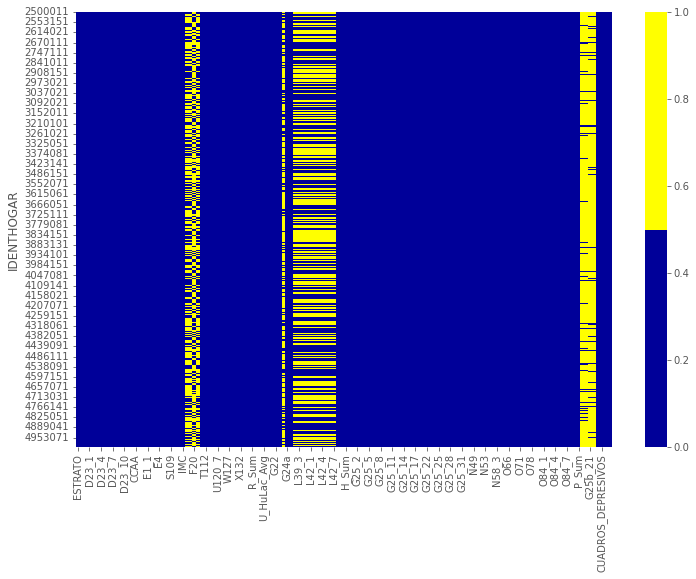

In [105]:
cols = df_full.columns
colours = ['#000099', '#ffff00']
sns.heatmap(df_full[cols].isnull(), cmap=sns.color_palette(colours))

In [106]:
r = df_full.isnull().any()
print (r[r].index)
len(r[r].index)

Index(['F18a_2', 'F19a_2', 'F20', 'J30', 'G24', 'L39_1', 'L39_3', 'L39_4',
       'L39_5', 'L42_1', 'L42_2', 'L42_3', 'L42_4', 'L42_5', 'L42_6', 'L42_7',
       'G25b_20', 'G25c_20', 'G25b_21', 'G25c_21'],
      dtype='object')


20

Se observa que aún tenemos 20 atributos con esta condición, por lo que realizamos un tratamiento específico a cada caso. Volvemos a hacer uso de los ficheros de diseño de registro para entender su significado

Los atributos Fxx, tienen relación con la actividad económica del individuo, tienen relación entre sí, por lo que completamos los missing_values con la respuesta "No Contesta"

In [107]:
df_full['F18a_2'] = df_full['F18a_2'].fillna(0)
df_full['F19a_2'] = df_full['F19a_2'].fillna(0)
df_full['F20'] = df_full['F20'].fillna(9)
df_full['J30'] = df_full['J30'].fillna(9)

Igualmente hacemos con el atributo G24

In [108]:
df_full['G24'] = df_full['G24'].fillna(9)

Los atributos Lxx, tienen relación con la limitación de actividades cotidianas, por lo que creamos un atributo sintético, que agrupe si tiene dificultad o no en estas tareas. Y se eliminan las variables individuales.

In [109]:
df_full['L39_1'] = df_full['L39_1'].fillna(9)
df_full['L39_3'] = df_full['L39_3'].fillna(9)
df_full['L39_4'] = df_full['L39_4'].fillna(9)
df_full['L39_5'] = df_full['L39_5'].fillna(9)
df_full['L42_1'] = df_full['L42_1'].fillna(9)
df_full['L42_2'] = df_full['L42_2'].fillna(9)
df_full['L42_3'] = df_full['L42_3'].fillna(9)
df_full['L42_4'] = df_full['L42_4'].fillna(9)
df_full['L42_5'] = df_full['L42_5'].fillna(9)
df_full['L42_6'] = df_full['L42_6'].fillna(9)
df_full['L42_7'] = df_full['L42_7'].fillna(9)

In [110]:
#Funciones creadas en utilidades.py
df_full['L39'] = df_full.apply(ut.act_diaria, axis=1)
df_full['L42'] = df_full.apply(ut.act_hogar, axis=1)

In [111]:
df_full_drop = ['L39_1','L39_3','L39_4','L39_5','L42_1','L42_2','L42_3','L42_4','L42_5','L42_6','L42_7']
df_full.drop(df_full_drop,axis=1,inplace=True)

Y, los atributos G25x_20 y G25x_21, los mantenemos en el dataset, pero completamos los null con "no contesta"

In [112]:
df_full['G25b_20'] = df_full['G25b_20'].fillna(9)
df_full['G25c_20'] = df_full['G25c_20'].fillna(9)
df_full['G25b_21'] = df_full['G25b_21'].fillna(9)
df_full['G25c_21'] = df_full['G25c_21'].fillna(9)

Se revisa nuevamente si queda algún atributo con valores null

<AxesSubplot:ylabel='IDENTHOGAR'>

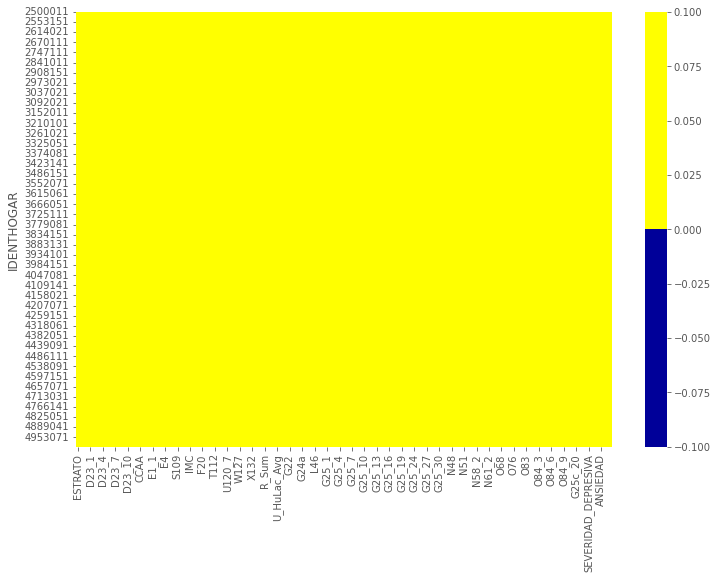

In [113]:
cols = df_full.columns
colours = ['#000099', '#ffff00']
sns.heatmap(df_full[cols].isnull(), cmap=sns.color_palette(colours))

In [114]:
r = df_full.isnull().any()
print (r[r].index)
len(r[r].index)

Index([], dtype='object')


0

In [115]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22072 entries, 2500011 to 4996151
Columns: 129 entries, ESTRATO to L42
dtypes: Int64(32), int64(97)
memory usage: 22.6 MB


En este punto tenemos un dataset con 129 atributos, y se procede a crear un nuevo punto de control, con el conjunto de datos que se utilizará en la siguiente fase del proceso KDD.

In [116]:
df_full.to_csv('full2020.csv')

### 8.- Reducción de los datos

En los pasos anteriores concatenamos varios conjuntos de datos, donde las variables objetivos (ansiedad y depresión) han quedado en columnas intermedias.

Por orden y mejor entendimiento en el análisis, reordenamos el dataframe, para que queden en las dos columnas finales.

In [117]:
df_clase_temp = df_full[['SEVERIDAD_DEPRESIVA','CUADROS_DEPRESIVOS','DEPRESION','ANSIEDAD']]

In [118]:
df_full.drop(['SEVERIDAD_DEPRESIVA','CUADROS_DEPRESIVOS','DEPRESION','ANSIEDAD'],axis=1,inplace=True)

In [119]:
df_full = pd.concat([df_full,df_clase_temp],axis=1)

In [120]:
df_full.head()

,ESTRATO,A11_i,A12,D23_1,D23_2,D23_3,D23_4,D23_5,D23_6,D23_7,...,G25b_20,G25c_20,G25b_21,G25c_21,L39,L42,SEVERIDAD_DEPRESIVA,CUADROS_DEPRESIVOS,DEPRESION,ANSIEDAD
IDENTHOGAR,,,,,,,,,,,,,,,,,,,,,
2500011,6,1,2,1,2,2,2,2,2,2,...,9,9,9,9,2,2,1,3,2,2
2500021,6,3,6,1,2,1,2,2,2,2,...,9,9,9,9,1,1,3,3,2,2
2500031,6,1,1,1,2,2,2,2,2,2,...,9,9,9,9,2,2,3,2,2,2
2500061,6,1,3,1,2,2,2,2,2,2,...,9,9,9,9,2,2,1,3,2,2
2500071,6,1,3,1,2,2,2,2,2,2,...,9,9,9,9,2,2,1,3,2,2


#### 8.1 - Análisis de valores repetidos

Los atributos cuyos valores tienden a ser constantes; es decir, tienen el mismo valor en todos sus registros, suelen aportar desinformación al modelo.

Así que procedemos a ver que variables muestran mucha repetitividad (>95%) sobre uno de sus valores, una vez filtrados los atributos, vemos si tienen alguna significancia con la depresión o la ansiedad

In [121]:
filas = len(df_full.index)
info = [] 

for col in df_full.columns:
    contar = df_full[col].value_counts(dropna=False)
    top_pct = (contar/filas).iloc[0]
    
    if top_pct > 0.95:
        info.append(col)
        print('{0}: {1:.5f}%'.format(col, top_pct*100))
        print(contar)
        print()

D23_4: 96.40721%
2       21279
1         793
<NA>        0
Name: D23_4, dtype: Int64

D23_5: 99.15730%
2       21886
1         186
<NA>        0
Name: D23_5, dtype: Int64

D23_6: 99.91845%
2       22054
1          18
<NA>        0
Name: D23_6, dtype: Int64

D23_7: 99.79612%
2       22027
1          45
<NA>        0
Name: D23_7, dtype: Int64

D23_8: 97.66673%
2       21557
1         515
<NA>        0
Name: D23_8, dtype: Int64

D23_9: 99.32494%
2       21923
1         149
<NA>        0
Name: D23_9, dtype: Int64

D23_10: 99.96375%
2       22064
1           8
<NA>        0
Name: D23_10, dtype: Int64

D23_11: 99.57865%
2       21979
1          93
<NA>        0
Name: D23_11, dtype: Int64

K_Sum: 97.64407%
1    21552
2      520
Name: K_Sum, dtype: int64

G25_2: 97.71203%
2    21567
1      496
3        9
Name: G25_2, dtype: int64

G25_3: 98.18775%
2    21672
1      391
3        9
Name: G25_3, dtype: int64

G25_11: 95.74574%
2    21133
1      910
3       29
Name: G25_11, dtype: int64

G25_13: 9

In [122]:
len(info)

34

Se encuentra entonces que hay 34 atributos que sus registros tienen el mismo valor.

Que siguiendo el significado de cada uno según el registro de diseño de las encuentas, son valores que responden a preguntas SI o NO.

In [123]:
print(info)

['D23_4', 'D23_5', 'D23_6', 'D23_7', 'D23_8', 'D23_9', 'D23_10', 'D23_11', 'K_Sum', 'G25_2', 'G25_3', 'G25_11', 'G25_13', 'G25_17', 'G25_18', 'G25_19', 'G25_22', 'G25_23', 'G25_26', 'G25_29', 'G25_30', 'G25_31', 'G25_32', 'N58_2', 'N61_1', 'N61_2', 'O84_1', 'O84_2', 'O84_3', 'O84_5', 'O84_6', 'O84_7', 'O84_8', 'O84_9']


In [124]:
att_no_significativo = ['D23_4','D23_5','D23_6','D23_7','D23_8','D23_9','D23_10','D23_11','G25_2','G25_3',
                       'G25_11','G25_13','G25_17','G25_18','G25_19','G25_22','G25_23','G25_26','G25_29',
                       'G25_30','G25_31','G25_32','N58_2','N61_1','N61_2','O84_2','O84_3','O84_5','O84_6',
                       'O84_7','O84_8','O84_9']

Inspeccionando cada una de estas variables según su significado en la encuesta, se procede a descartar todos los atributos, con mas del 95% de respuesta NO, ya que se asume que su no existencia no influye en la depresión o la ansiedad.

Unicamente dejamos en el dataset los atributos con mas de un 95% de SI

In [125]:
df_full.drop(att_no_significativo,axis=1,inplace=True)

#### 8.2 - Cambio de nombre de los atributos

Un paso que no se ha ejecutado hasta el momento, es adaptar los códigos de las variables origen con una nomenclatura que tenga mas significancia en las siguientes fases. Asñi, se facilita la inspección y análisis en la fase del análisis exploratorio.

In [126]:
df_full.columns

Index(['ESTRATO', 'A11_i', 'A12', 'D23_1', 'D23_2', 'D23_3', 'D26', 'CCAA',
       'SEXOa', 'EDADa', 'E1_1', 'E2_1a', 'E2_1b', 'E4', 'E4b', 'ESTUDIOS',
       'S109', 'S110', 'CLASE_PR', 'IMC', 'F18a_2', 'F19a_2', 'F20', 'J30',
       'T111', 'T112', 'U120_2', 'U120_4', 'U120_7', 'U120_8', 'V121', 'W127',
       'X130', 'X131', 'X132', 'Y133', 'Y135', 'R_Sum', 'U_fruta_Avg',
       'U_NoFood_Avg', 'U_HuLac_Avg', 'U_Carb_Avg', 'G21', 'G22', 'G23', 'G24',
       'G24a', 'K38a', 'L45', 'L46', 'H_Sum', 'K_Sum', 'G25_1', 'G25_4',
       'G25_5', 'G25_6', 'G25_7', 'G25_8', 'G25_9', 'G25_10', 'G25_12',
       'G25_14', 'G25_15', 'G25_16', 'G25_24', 'G25_25', 'G25_27', 'G25_28',
       'N48', 'N49', 'N50', 'N51', 'N53', 'N57', 'N58_3', 'O66', 'O67', 'O68',
       'O71', 'O75', 'O76', 'O78', 'O79', 'O83', 'O84_1', 'O84_4', 'P_Sum',
       'G25b_20', 'G25c_20', 'G25b_21', 'G25c_21', 'L39', 'L42',
       'SEVERIDAD_DEPRESIVA', 'CUADROS_DEPRESIVOS', 'DEPRESION', 'ANSIEDAD'],
      dtype='object')

In [127]:
df_full.rename(columns={'ESTRATO' : 'tipo_municipio',
                        'A11_i'   : 'situacion_laboral',
                        'A12'     : 'tipo_hogar',
                        'D23_1'   : 'tipo_contrato',
                        'D23_2'   : 'tipo_ayuda',
                        'D23_3'   : 'tipo_jubilacion',
                        'D26'     : 'salario_neto',
                        'CCAA'    : 'comunidad_autonoma',
                        'SEXOa'   : 'sexo',
                        'EDADa'   : 'edad',
                        'E1_1'    : 'pais_nacimiento',
                        'E2_1a'   : 'nacionalidad_espanola',
                        'E2_1b'   : 'nacionalidad_extranjera',
                        'E4'      : 'tipo_convivencia',
                        'E4b'     : 'estado_civil',
                        'ESTUDIOS': 'nivel_estudios',
                        'S109'    : 'altura',
                        'S110'    : 'peso',
                        'CLASE_PR': 'clase_social',
                        'IMC'     : 'imc',
                        'F18a_2'  : 'actividad_empresa',
                        'F19a_2'  : 'ocupacion',
                        'F20'     : 'situacion_profesional',
                        'J30'     : 'ausencia_laboral12m',
                        'T111'    : 'tipo_actfisica',
                        'T112'    : 'frecuencia_actfisica',
                        'U120_2'  : 'frecuencia_consumocarne',
                        'U120_4'  : 'frecuencia_consumopescado',
                        'U120_7'  : 'frecuencia_consumoverdura',
                        'U120_8'  : 'frecuencia_consumolegumbre',
                        'V121'    : 'fumador',
                        'W127'    : 'frecuencia_consumoalcohol',
                        'X130'    : 'apoyosocial_cuantos',
                        'X131'    : 'apoyosocial_interes',
                        'X132'    : 'apoyosocial_ayuda',
                        'Y133'    : 'cuidado_personas',
                        'Y135'    : 'cuidado_horas',
                        'R_Sum'   : 'falta_atencionsanitaria',
                        'U_fruta_Avg' : 'frecuencia_consumofruta',
                        'U_NoFood_Avg': 'frecuencia_consumoprocesado',
                        'U_HuLac_Avg' : 'frecuencia_consumohuevoslacteos',
                        'U_Carb_Avg'  : 'frecuencia_consumocarbohidratos',
                        'G21'     : 'estado_salud12m',
                        'G22'     : 'estado_saludcronico',
                        'G23'     : 'limitacion_salud6m',
                        'G24'     : 'tipo_problemasalud',
                        'G24a'    : 'estado_saludbucodental',
                        'K38a'    : 'dificultad_concentracion',
                        'L45'     : 'dolor_4semanas',
                        'L46'     : 'dolor_limitacion',
                        'H_Sum'   : 'accidentes_12meses',
                        'K_Sum'   : 'limitacion_fisica',
                        'G25_1'   : 'tension_alta',
                        'G25_4'   : 'enfermedad_corazon',
                        'G25_5'   : 'varices',
                        'G25_6'   : 'artrosis',
                        'G25_7'   : 'dolor_cervical',
                        'G25_8'   : 'dolor_lumbar',
                        'G25_9'   : 'alergias',
                        'G25_10'  : 'asma',
                        'G25_12'  : 'diabetes',
                        'G25_14'  : 'orina',
                        'G25_15'  : 'colesterol',
                        'G25_16'  : 'cataratas',
                        'G25_24'  : 'migrana',
                        'G25_25'  : 'hemorroides',
                        'G25_27'  : 'osteoporosis',
                        'G25_28'  : 'tiroides',
                        'N48'     : 'ultima_consultamedica',
                        'N49'     : 'cantidad_consultageneral4sem',
                        'N50'     : 'tiempo_ultimaconsulta',
                        'N51'     : 'cantidad_consultaespecialista4sem',
                        'N53'     : 'lugar_consulta4sem',
                        'N57'     : 'tipo_consultamedica',
                        'N58_3'   : 'consulta_enfermeria12m',
                        'O66'     : 'ingreso_hospital12m',
                        'O67'     : 'cantidad_ingresohospital12m',
                        'O68'     : 'numero_nocheshospital12m',
                        'O71'     : 'motivo_ingresohospital',
                        'O75'     : 'ingreso_hospitaldia12m',
                        'O76'     : 'cantidad_ingresohospitaldia12m',
                        'O78'     : 'urgencia_12meses',
                        'O79'     : 'cantidad_urgencias12m',
                        'O83'     : 'tipo_urgencia',
                        'O84_1'   : 'uso_sanidadpublica',
                        'O84_4'   : 'uso_seguroprivado',
                        'P_Sum'   : 'consumo_medicamentos',
                        'G25b_20' : 'depresion_12meses',
                        'G25c_20' : 'depresion_diagnosticomedico',
                        'G25b_21' : 'ansiedad_12meses',
                        'G25c_21' : 'ansiedad_diagnosticomedico',
                        'L39'     : 'dificultad_actdiaria',
                        'L42'     : 'dificultad_acthogar',
                        'SEVERIDAD_DEPRESIVA' : 'nivel_depresion',
                        'CUADROS_DEPRESIVOS'  : 'prevalencia_depresion',
                        'DEPRESION' : 'depresion',
                        'ANSIEDAD' : 'ansiedad'}, inplace=True)

In [128]:
df_full.head()

,tipo_municipio,situacion_laboral,tipo_hogar,tipo_contrato,tipo_ayuda,tipo_jubilacion,salario_neto,comunidad_autonoma,sexo,edad,...,depresion_12meses,depresion_diagnosticomedico,ansiedad_12meses,ansiedad_diagnosticomedico,dificultad_actdiaria,dificultad_acthogar,nivel_depresion,prevalencia_depresion,depresion,ansiedad
IDENTHOGAR,,,,,,,,,,,,,,,,,,,,,
2500011,6,1,2,1,2,2,99,16,1,60,...,9,9,9,9,2,2,1,3,2,2
2500021,6,3,6,1,2,1,99,16,2,87,...,9,9,9,9,1,1,3,3,2,2
2500031,6,1,1,1,2,2,2,16,1,38,...,9,9,9,9,2,2,3,2,2,2
2500061,6,1,3,1,2,2,99,16,2,43,...,9,9,9,9,2,2,1,3,2,2
2500071,6,1,3,1,2,2,99,16,1,41,...,9,9,9,9,2,2,1,3,2,2


#### 8.3- Creación de los conjuntos de datos de estudio

La fase de limpieza y preprocesamiento de datos, se ha realizado inspeccionando si las variables tienen o no relación con la ansiedad o la depresión.

Pero, para el análisis exploratorio y posterior construcción de los modelos, se debe analizar cada enfermedad por separado.

Por lo que creamos dos conjuntos de datos con una sola variable objetivo por enfermedad.

Se crea un dataset con los atributos generales, no relacionados directamente con ninguna de las enfermedades

In [129]:
att_generales = ['tipo_municipio', 'situacion_laboral', 'tipo_hogar', 'tipo_contrato',
       'tipo_ayuda', 'tipo_jubilacion', 'salario_neto', 'comunidad_autonoma', 'sexo', 'edad', 'pais_nacimiento',
       'nacionalidad_espanola', 'nacionalidad_extranjera', 'tipo_convivencia',
       'estado_civil', 'nivel_estudios', 'altura', 'peso', 'clase_social',
       'imc', 'actividad_empresa', 'ocupacion', 'situacion_profesional',
       'ausencia_laboral12m', 'tipo_actfisica', 'frecuencia_actfisica',
       'frecuencia_consumocarne', 'frecuencia_consumopescado',
       'frecuencia_consumoverdura', 'frecuencia_consumolegumbre', 'fumador',
       'frecuencia_consumoalcohol', 'apoyosocial_cuantos',
       'apoyosocial_interes', 'apoyosocial_ayuda', 'cuidado_personas',
       'cuidado_horas', 'falta_atencionsanitaria', 'frecuencia_consumofruta',
       'frecuencia_consumoprocesado', 'frecuencia_consumohuevoslacteos',
       'frecuencia_consumocarbohidratos', 'estado_salud12m',
       'estado_saludcronico', 'limitacion_salud6m', 'tipo_problemasalud',
       'estado_saludbucodental', 'dificultad_concentracion', 'dolor_4semanas',
       'dolor_limitacion', 'accidentes_12meses', 'limitacion_fisica',
       'tension_alta', 'enfermedad_corazon', 'varices', 'artrosis',
       'dolor_cervical', 'dolor_lumbar', 'alergias', 'asma', 'diabetes',
       'orina', 'colesterol', 'cataratas', 'migrana', 'hemorroides',
       'osteoporosis', 'tiroides', 'ultima_consultamedica',
       'cantidad_consultageneral4sem', 'tiempo_ultimaconsulta',
       'cantidad_consultaespecialista4sem', 'lugar_consulta4sem',
       'tipo_consultamedica', 'consulta_enfermeria12m', 'ingreso_hospital12m',
       'cantidad_ingresohospital12m', 'numero_nocheshospital12m',
       'motivo_ingresohospital', 'ingreso_hospitaldia12m',
       'cantidad_ingresohospitaldia12m', 'urgencia_12meses',
       'cantidad_urgencias12m', 'tipo_urgencia', 'uso_sanidadpublica',
       'uso_seguroprivado', 'consumo_medicamentos','dificultad_actdiaria',
       'dificultad_acthogar']

In [130]:
df_variables = df_full[att_generales]

##### 8.3.1- Dataset "Depresión"

Se crea un dataset con las variables asociadas con la depresión, incluyendo el target "depresion"

In [131]:
att_depresion = ['depresion_12meses','depresion_diagnosticomedico','nivel_depresion', 'prevalencia_depresion',
                 'depresion']

In [132]:
df_variables_depresion = df_full[att_depresion]

In [133]:
df_depresion = pd.concat([df_variables,df_variables_depresion],axis=1)

In [134]:
df_depresion.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22072 entries, 2500011 to 4996151
Data columns (total 94 columns):
 #   Column                             Non-Null Count  Dtype
---  ------                             --------------  -----
 0   tipo_municipio                     22072 non-null  int64
 1   situacion_laboral                  22072 non-null  int64
 2   tipo_hogar                         22072 non-null  int64
 3   tipo_contrato                      22072 non-null  Int64
 4   tipo_ayuda                         22072 non-null  Int64
 5   tipo_jubilacion                    22072 non-null  Int64
 6   salario_neto                       22072 non-null  int64
 7   comunidad_autonoma                 22072 non-null  int64
 8   sexo                               22072 non-null  int64
 9   edad                               22072 non-null  int64
 10  pais_nacimiento                    22072 non-null  int64
 11  nacionalidad_espanola              22072 non-null  int64
 12  nacionalid

##### 8.3.2- Dataset "Ansiedad"

Se crea un dataset con las variables asociadas con la ansiedad, incluyendo el target "ansiedad"

In [135]:
att_ansiedad = ['ansiedad_12meses','ansiedad_diagnosticomedico','ansiedad']

In [136]:
df_variables_ansiedad = df_full[att_ansiedad]

In [137]:
df_ansiedad = pd.concat([df_variables,df_variables_ansiedad],axis=1)

In [138]:
df_ansiedad.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22072 entries, 2500011 to 4996151
Data columns (total 92 columns):
 #   Column                             Non-Null Count  Dtype
---  ------                             --------------  -----
 0   tipo_municipio                     22072 non-null  int64
 1   situacion_laboral                  22072 non-null  int64
 2   tipo_hogar                         22072 non-null  int64
 3   tipo_contrato                      22072 non-null  Int64
 4   tipo_ayuda                         22072 non-null  Int64
 5   tipo_jubilacion                    22072 non-null  Int64
 6   salario_neto                       22072 non-null  int64
 7   comunidad_autonoma                 22072 non-null  int64
 8   sexo                               22072 non-null  int64
 9   edad                               22072 non-null  int64
 10  pais_nacimiento                    22072 non-null  int64
 11  nacionalidad_espanola              22072 non-null  int64
 12  nacionalid

Los dos datasets tienen todas las variables del dataset concatenado asociadas a la enfermedad a analizar, y el target (ansiedad o depresión).

Guardamos en un fichero .csv ambos datasets

In [139]:
df_ansiedad.to_csv('ansiedad2020.csv')
df_depresion.to_csv('depresion2020.csv')

#### 8.4- Normalización de los datos de entrada

Es importante normalizar antes de ejecutar los modelos para tener un rango definido de todas las variables que forman parte del algoritmo.

Uno de los detalles interesantes del conjunto de datos, es que hasta ahora hemos estado trabajando con variables numéricas discretas. En ningún momento se han utilizado variables categóricas.

Así, que la normalización de las variables para su posterior estudio de correlación, se centra solo en normalizar o escalar. No se aplicarán técnicas de One-Hot Encoding orientadas a discretizar variables categóricas.

En este caso aplicaremos el "escalado" (0-1) de las variables, porque estamos trabajando en valores positivos. 

Este paso solo aplica a las variables, dejando por fuera al target.

Aún no se han hecho inspecciones sobre valores atípicos(outliers), principalmente por la gran cantidad de variables y porque todos los registros aportan una respuesta necesaria para la detección de patrones asociados a la ansiedad o la depresión

Por ello se utilizará el método de escalado "QuantileTransformer", que es un método ofrecido por scikit-learn, que toma en cuenta este tipo de datos en su normalización para agruparlos en el rango.

In [140]:
df_ansiedad.head()

,tipo_municipio,situacion_laboral,tipo_hogar,tipo_contrato,tipo_ayuda,tipo_jubilacion,salario_neto,comunidad_autonoma,sexo,edad,...,cantidad_urgencias12m,tipo_urgencia,uso_sanidadpublica,uso_seguroprivado,consumo_medicamentos,dificultad_actdiaria,dificultad_acthogar,ansiedad_12meses,ansiedad_diagnosticomedico,ansiedad
IDENTHOGAR,,,,,,,,,,,,,,,,,,,,,
2500011,6,1,2,1,2,2,99,16,1,60,...,0,9,1,2,0,2,2,9,9,2
2500021,6,3,6,1,2,1,99,16,2,87,...,1,1,1,1,8,1,1,9,9,2
2500031,6,1,1,1,2,2,2,16,1,38,...,1,4,1,2,1,2,2,9,9,2
2500061,6,1,3,1,2,2,99,16,2,43,...,1,4,1,1,2,2,2,9,9,2
2500071,6,1,3,1,2,2,99,16,1,41,...,0,9,1,2,1,2,2,9,9,2


In [141]:
df_depresion.head()

,tipo_municipio,situacion_laboral,tipo_hogar,tipo_contrato,tipo_ayuda,tipo_jubilacion,salario_neto,comunidad_autonoma,sexo,edad,...,uso_sanidadpublica,uso_seguroprivado,consumo_medicamentos,dificultad_actdiaria,dificultad_acthogar,depresion_12meses,depresion_diagnosticomedico,nivel_depresion,prevalencia_depresion,depresion
IDENTHOGAR,,,,,,,,,,,,,,,,,,,,,
2500011,6,1,2,1,2,2,99,16,1,60,...,1,2,0,2,2,9,9,1,3,2
2500021,6,3,6,1,2,1,99,16,2,87,...,1,1,8,1,1,9,9,3,3,2
2500031,6,1,1,1,2,2,2,16,1,38,...,1,2,1,2,2,9,9,3,2,2
2500061,6,1,3,1,2,2,99,16,2,43,...,1,1,2,2,2,9,9,1,3,2
2500071,6,1,3,1,2,2,99,16,1,41,...,1,2,1,2,2,9,9,1,3,2


In [142]:
# Eliminamos las variables objetivo de los dataset, para proceder al análisis de correlaciones y variables 
#significativas
X_ansiedad = df_ansiedad.drop('ansiedad', axis=1)
X_depresion = df_depresion.drop('depresion', axis=1)

In [143]:
# Se crean los dataset con las variables objetivo
y_ansiedad = df_ansiedad.ansiedad
y_depresion = df_depresion.depresion

In [144]:
print(y_ansiedad.value_counts())
print(y_depresion.value_counts())

2    20279
1     1793
Name: ansiedad, dtype: int64
2    19957
1     2115
Name: depresion, dtype: int64


In [145]:
qt = QuantileTransformer(random_state=123)

In [146]:
X_ansiedad_norm = qt.fit_transform(X_ansiedad)
X_depresion_norm = qt.fit_transform(X_depresion)

In [147]:
#Reconstruimos los Dataframes
df_ansiedad_norm = pd.DataFrame(X_ansiedad_norm, columns=X_ansiedad.columns,
                                     index=X_ansiedad.index)
df_depresion_norm = pd.DataFrame(X_depresion_norm, columns=X_depresion.columns,
                                     index=X_depresion.index)

In [148]:
#Hago un reset en los indices
df_ansiedad_norm=df_ansiedad_norm.reset_index()
df_depresion_norm=df_depresion_norm.reset_index()

In [149]:
df_ansiedad_norm.head()

,IDENTHOGAR,tipo_municipio,situacion_laboral,tipo_hogar,tipo_contrato,tipo_ayuda,tipo_jubilacion,salario_neto,comunidad_autonoma,sexo,...,urgencia_12meses,cantidad_urgencias12m,tipo_urgencia,uso_sanidadpublica,uso_seguroprivado,consumo_medicamentos,dificultad_actdiaria,dificultad_acthogar,ansiedad_12meses,ansiedad_diagnosticomedico
0,2500011,1.0,0.000000,0.387387,0.0,1.0,1.0,1.000000,0.918919,0.0,...,1.0,0.000000,1.000000,0.0,1.0,0.000000,1.0,1.0,1.0,1.0
1,2500021,1.0,0.681682,0.890891,0.0,1.0,0.0,1.000000,0.918919,1.0,...,0.0,0.842342,0.000000,0.0,0.0,0.988488,0.0,0.0,1.0,1.0
2,2500031,1.0,0.000000,0.000000,0.0,1.0,1.0,0.400901,0.918919,0.0,...,0.0,0.842342,0.226226,0.0,1.0,0.463964,1.0,1.0,1.0,1.0
3,2500061,1.0,0.000000,0.624124,0.0,1.0,1.0,1.000000,0.918919,1.0,...,0.0,0.842342,0.226226,0.0,0.0,0.646647,1.0,1.0,1.0,1.0
4,2500071,1.0,0.000000,0.624124,0.0,1.0,1.0,1.000000,0.918919,0.0,...,1.0,0.000000,1.000000,0.0,1.0,0.463964,1.0,1.0,1.0,1.0


In [150]:
df_depresion_norm.head()

,IDENTHOGAR,tipo_municipio,situacion_laboral,tipo_hogar,tipo_contrato,tipo_ayuda,tipo_jubilacion,salario_neto,comunidad_autonoma,sexo,...,tipo_urgencia,uso_sanidadpublica,uso_seguroprivado,consumo_medicamentos,dificultad_actdiaria,dificultad_acthogar,depresion_12meses,depresion_diagnosticomedico,nivel_depresion,prevalencia_depresion
0,2500011,1.0,0.000000,0.387387,0.0,1.0,1.0,1.000000,0.918919,0.0,...,1.000000,0.0,1.0,0.000000,1.0,1.0,1.0,1.0,0.000000,0.527027
1,2500021,1.0,0.681682,0.890891,0.0,1.0,0.0,1.000000,0.918919,1.0,...,0.000000,0.0,0.0,0.988488,0.0,0.0,1.0,1.0,0.958458,0.527027
2,2500031,1.0,0.000000,0.000000,0.0,1.0,1.0,0.400901,0.918919,0.0,...,0.226226,0.0,1.0,0.463964,1.0,1.0,1.0,1.0,0.958458,0.045045
3,2500061,1.0,0.000000,0.624124,0.0,1.0,1.0,1.000000,0.918919,1.0,...,0.226226,0.0,0.0,0.646647,1.0,1.0,1.0,1.0,0.000000,0.527027
4,2500071,1.0,0.000000,0.624124,0.0,1.0,1.0,1.000000,0.918919,0.0,...,1.000000,0.0,1.0,0.463964,1.0,1.0,1.0,1.0,0.000000,0.527027


#### 8.5- Estudio de correlaciones y características significativas

Para el estudio de las correlaciones y selección de variables sognificativas, se hará uso de una herramienta de reducción de la dimensional disponible en GitHub y escrita por Will Koehrsen.

[feature-selector](https://github.com/WillKoehrsen/feature-selector.git)

Esta herramienta consta de cinco métodos para poder ser usados en la fase de Reducción de Datos.

En el caso de este proyecto, solo se hará uso de las siguientes:

* __Estudio de Correlaciones:__ este método haciendo uso del coeficiente de Peason, permite analizar colinealidades en parejas de variables; tras varias pruebas se decide como estrategia del análisis seleccionar las correlaciones mayores a 0.90
* __Características sin Importancia__: este método haciendo uso de la libreria [LightGBM library](https://lightgbm.readthedocs.io/en/latest/index.html), ejecuta un conjunto de modelo basado en la potenciación del gradiente, para determinar la importancia de todas las variables respecto a al clase que se quiere identificar. En este primer método identificar las que devuelven un valor de 0.
* __Características con baja Importancia__: como resultado del método anterior, se escogen que variables tienen una baja infñuencia en la clase a identificar, seleccionando como estrategía el porcentaje de variables que explicarían la clase. En este caso se ha seleccionado el valor de 0.99

Por último, esta herramienta es capaz de identificar y borrar las variables que se descartan de los trés métodos anteriores.

In [151]:
fs_ansiedad = FeatureSelector(data = df_ansiedad_norm, labels= y_ansiedad)
fs_depresion = FeatureSelector(data = df_depresion_norm, labels= y_depresion)

##### 8.5.1- Dataset "Ansiedad"

In [152]:
fs_ansiedad.identify_collinear(correlation_threshold=0.90)

14 features with a correlation magnitude greater than 0.90.



In [153]:
correlated_features = fs_ansiedad.ops['collinear']
correlated_features

['nacionalidad_extranjera',
 'ocupacion',
 'ausencia_laboral12m',
 'cuidado_horas',
 'tipo_problemasalud',
 'lugar_consulta4sem',
 'tipo_consultamedica',
 'cantidad_ingresohospital12m',
 'numero_nocheshospital12m',
 'motivo_ingresohospital',
 'cantidad_ingresohospitaldia12m',
 'cantidad_urgencias12m',
 'tipo_urgencia',
 'ansiedad_diagnosticomedico']

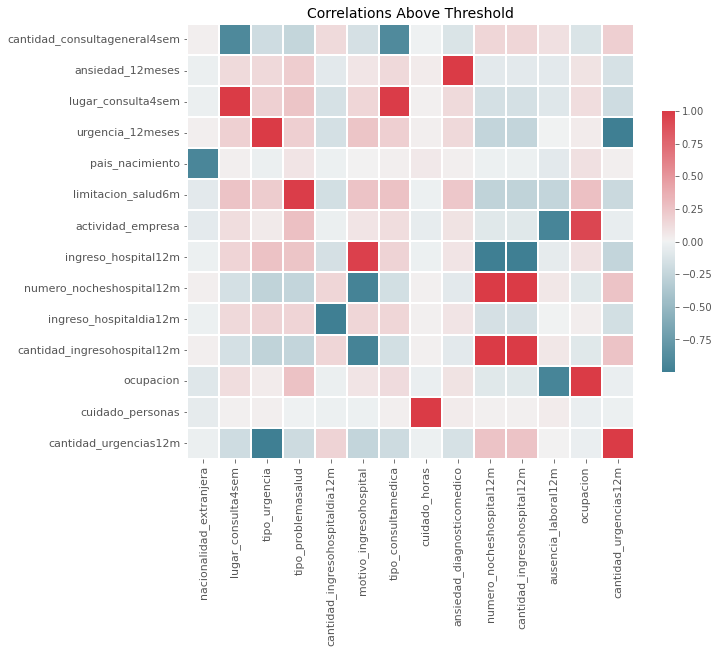

In [154]:
fs_ansiedad.plot_collinear()

In [155]:
fs_ansiedad.record_collinear

,drop_feature,corr_feature,corr_value
0,nacionalidad_extranjera,pais_nacimiento,-0.934667
1,ocupacion,actividad_empresa,0.936745
2,ausencia_laboral12m,actividad_empresa,-0.947221
3,ausencia_laboral12m,ocupacion,-0.945532
4,cuidado_horas,cuidado_personas,0.994245
5,tipo_problemasalud,limitacion_salud6m,0.977455
6,lugar_consulta4sem,cantidad_consultageneral4sem,-0.909879
7,tipo_consultamedica,cantidad_consultageneral4sem,-0.902845
8,tipo_consultamedica,lugar_consulta4sem,0.990977
9,cantidad_ingresohospital12m,ingreso_hospital12m,-0.99772


In [156]:
fs_ansiedad.identify_zero_importance(task = 'classification', eval_metric = 'auc', 
                            n_iterations = 10, early_stopping = True)

Training Gradient Boosting Model


65 features with zero importance after one-hot encoding.



In [157]:
zero_importance_features = fs_ansiedad.ops['zero_importance']
print(zero_importance_features)

['tiroides', 'alergias', 'migrana', 'asma', 'dolor_lumbar', 'cataratas', 'orina', 'diabetes', 'ultima_consultamedica', 'tipo_consultamedica', 'tiempo_ultimaconsulta', 'cantidad_consultaespecialista4sem', 'dificultad_acthogar', 'dificultad_actdiaria', 'consumo_medicamentos', 'uso_seguroprivado', 'uso_sanidadpublica', 'tipo_urgencia', 'urgencia_12meses', 'cantidad_ingresohospitaldia12m', 'ingreso_hospitaldia12m', 'motivo_ingresohospital', 'cantidad_ingresohospital12m', 'ingreso_hospital12m', 'consulta_enfermeria12m', 'artrosis', 'lugar_consulta4sem', 'dolor_cervical', 'dolor_limitacion', 'varices', 'enfermedad_corazon', 'frecuencia_consumoverdura', 'frecuencia_consumopescado', 'frecuencia_consumocarne', 'frecuencia_actfisica', 'tipo_actfisica', 'ausencia_laboral12m', 'tipo_contrato', 'imc', 'clase_social', 'tipo_ayuda', 'tipo_jubilacion', 'tipo_convivencia', 'nacionalidad_extranjera', 'nacionalidad_espanola', 'pais_nacimiento', 'frecuencia_consumolegumbre', 'fumador', 'apoyosocial_cuanto

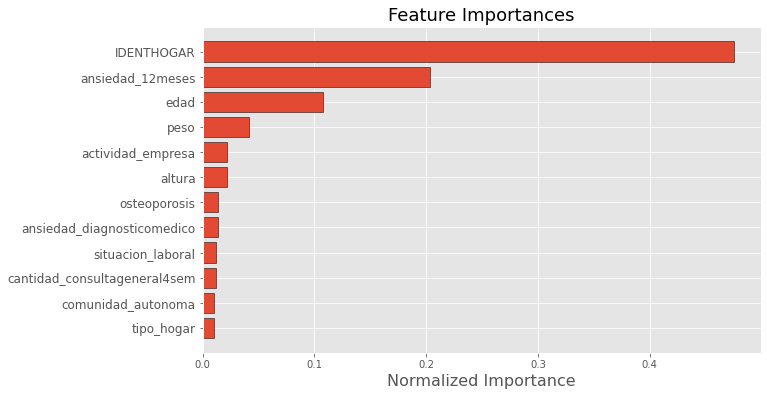

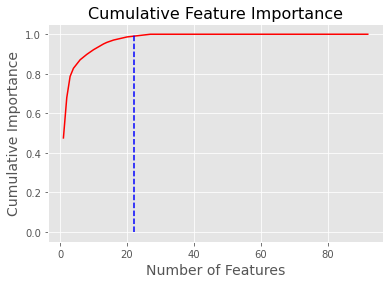

22 features required for 0.99 of cumulative importance


In [158]:
fs_ansiedad.plot_feature_importances(threshold = 0.99, plot_n = 12)

In [159]:
fs_ansiedad.feature_importances.head(9)

,feature,importance,normalized_importance,cumulative_importance
0,IDENTHOGAR,24.3,0.475538,0.475538
1,ansiedad_12meses,10.4,0.203523,0.679061
2,edad,5.5,0.107632,0.786693
3,peso,2.1,0.041096,0.827789
4,actividad_empresa,1.1,0.021526,0.849315
5,altura,1.1,0.021526,0.870841
6,osteoporosis,0.7,0.013699,0.884540
7,ansiedad_diagnosticomedico,0.7,0.013699,0.898239
8,situacion_laboral,0.6,0.011742,0.909980


In [160]:
fs_ansiedad.identify_low_importance(cumulative_importance = 0.99)

21 features required for cumulative importance of 0.99 after one hot encoding.
71 features do not contribute to cumulative importance of 0.99.



In [161]:
low_importance_features = fs_ansiedad.ops['low_importance']
print(low_importance_features)

['frecuencia_consumofruta', 'colesterol', 'cantidad_urgencias12m', 'frecuencia_consumoalcohol', 'situacion_profesional', 'pais_nacimiento', 'nacionalidad_espanola', 'nacionalidad_extranjera', 'tipo_convivencia', 'tipo_jubilacion', 'tipo_ayuda', 'tipo_contrato', 'imc', 'frecuencia_consumolegumbre', 'ausencia_laboral12m', 'tipo_actfisica', 'frecuencia_actfisica', 'frecuencia_consumocarne', 'clase_social', 'fumador', 'frecuencia_consumoprocesado', 'estado_saludbucodental', 'tension_alta', 'limitacion_fisica', 'accidentes_12meses', 'sexo', 'dolor_4semanas', 'dificultad_concentracion', 'limitacion_salud6m', 'apoyosocial_ayuda', 'estado_saludcronico', 'estado_salud12m', 'frecuencia_consumopescado', 'falta_atencionsanitaria', 'cuidado_horas', 'apoyosocial_cuantos', 'frecuencia_consumoverdura', 'urgencia_12meses', 'varices', 'frecuencia_consumohuevoslacteos', 'tiroides', 'alergias', 'migrana', 'asma', 'dolor_lumbar', 'cataratas', 'orina', 'diabetes', 'ultima_consultamedica', 'tipo_consultamedi

##### 8.5.2- Dataset "Depresion"

In [162]:
fs_depresion.identify_collinear(correlation_threshold=0.90)

14 features with a correlation magnitude greater than 0.90.



In [163]:
correlated_features2 = fs_depresion.ops['collinear']
correlated_features2

['nacionalidad_extranjera',
 'ocupacion',
 'ausencia_laboral12m',
 'cuidado_horas',
 'tipo_problemasalud',
 'lugar_consulta4sem',
 'tipo_consultamedica',
 'cantidad_ingresohospital12m',
 'numero_nocheshospital12m',
 'motivo_ingresohospital',
 'cantidad_ingresohospitaldia12m',
 'cantidad_urgencias12m',
 'tipo_urgencia',
 'depresion_diagnosticomedico']

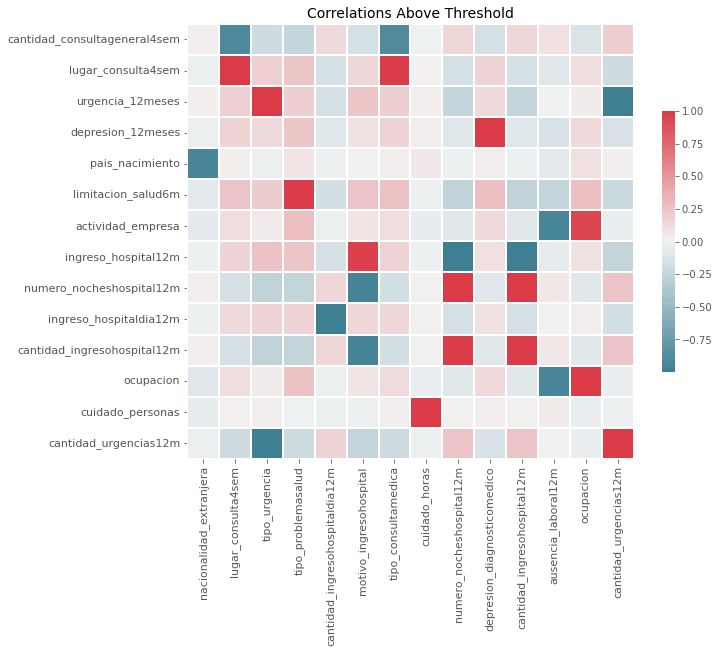

In [164]:
fs_depresion.plot_collinear()

In [165]:
fs_depresion.record_collinear

,drop_feature,corr_feature,corr_value
0,nacionalidad_extranjera,pais_nacimiento,-0.934667
1,ocupacion,actividad_empresa,0.936745
2,ausencia_laboral12m,actividad_empresa,-0.947221
3,ausencia_laboral12m,ocupacion,-0.945532
4,cuidado_horas,cuidado_personas,0.994245
5,tipo_problemasalud,limitacion_salud6m,0.977455
6,lugar_consulta4sem,cantidad_consultageneral4sem,-0.909879
7,tipo_consultamedica,cantidad_consultageneral4sem,-0.902845
8,tipo_consultamedica,lugar_consulta4sem,0.990977
9,cantidad_ingresohospital12m,ingreso_hospital12m,-0.99772


In [166]:
fs_depresion.identify_zero_importance(task = 'classification', eval_metric = 'auc', 
                            n_iterations = 10, early_stopping = True)

Training Gradient Boosting Model


34 features with zero importance after one-hot encoding.



In [167]:
zero_importance_features2 = fs_depresion.ops['zero_importance']
print(zero_importance_features2)

['frecuencia_consumoprocesado', 'ingreso_hospital12m', 'cantidad_urgencias12m', 'ingreso_hospitaldia12m', 'urgencia_12meses', 'tipo_consultamedica', 'uso_sanidadpublica', 'uso_seguroprivado', 'nacionalidad_extranjera', 'nacionalidad_espanola', 'pais_nacimiento', 'tipo_jubilacion', 'tipo_ayuda', 'consulta_enfermeria12m', 'osteoporosis', 'situacion_profesional', 'varices', 'cuidado_horas', 'cuidado_personas', 'frecuencia_consumoverdura', 'accidentes_12meses', 'limitacion_fisica', 'tension_alta', 'enfermedad_corazon', 'artrosis', 'cantidad_consultageneral4sem', 'dolor_cervical', 'dolor_lumbar', 'alergias', 'asma', 'migrana', 'tiroides', 'ultima_consultamedica', 'estado_saludbucodental']


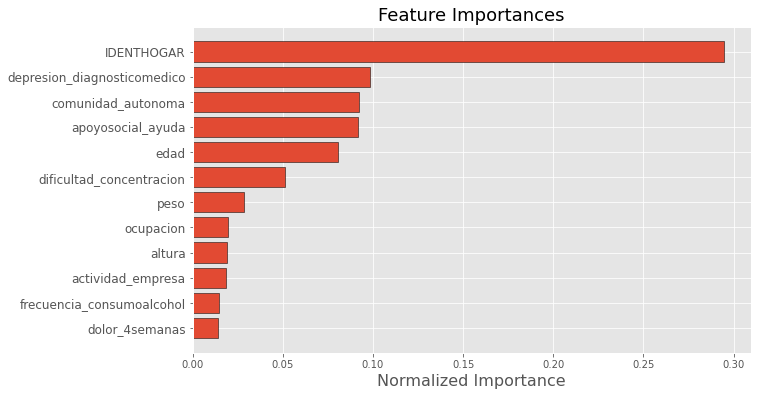

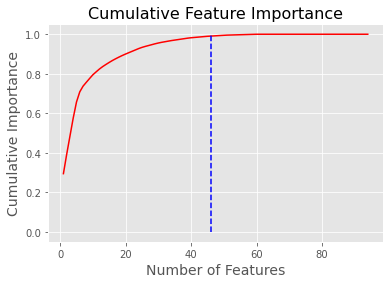

46 features required for 0.99 of cumulative importance


In [168]:
fs_depresion.plot_feature_importances(threshold = 0.99, plot_n = 12)

In [169]:
fs_depresion.feature_importances.head(39)

,feature,importance,normalized_importance,cumulative_importance
0,IDENTHOGAR,59.8,0.294726,0.294726
1,depresion_diagnosticomedico,19.9,0.098078,0.392804
2,comunidad_autonoma,18.7,0.092164,0.484968
3,apoyosocial_ayuda,18.6,0.091671,0.576639
4,edad,16.4,0.080828,0.657467
5,dificultad_concentracion,10.4,0.051257,0.708724
6,peso,5.8,0.028586,0.737309
7,ocupacion,4.0,0.019714,0.757023
8,altura,3.9,0.019221,0.776244
9,actividad_empresa,3.8,0.018728,0.794973


In [170]:
fs_depresion.identify_low_importance(cumulative_importance = 0.99)

45 features required for cumulative importance of 0.99 after one hot encoding.
49 features do not contribute to cumulative importance of 0.99.



In [171]:
low_importance_features2 = fs_depresion.ops['low_importance']
print(low_importance_features2)

['frecuencia_actfisica', 'frecuencia_consumohuevoslacteos', 'frecuencia_consumocarne', 'cantidad_ingresohospitaldia12m', 'estado_saludcronico', 'frecuencia_consumocarbohidratos', 'frecuencia_consumolegumbre', 'apoyosocial_cuantos', 'orina', 'tiempo_ultimaconsulta', 'numero_nocheshospital12m', 'hemorroides', 'tipo_urgencia', 'cantidad_consultaespecialista4sem', 'cuidado_personas', 'frecuencia_consumoverdura', 'accidentes_12meses', 'limitacion_fisica', 'tension_alta', 'enfermedad_corazon', 'artrosis', 'migrana', 'dolor_cervical', 'dolor_lumbar', 'alergias', 'asma', 'cuidado_horas', 'tiroides', 'cantidad_consultageneral4sem', 'varices', 'pais_nacimiento', 'osteoporosis', 'ausencia_laboral12m', 'frecuencia_consumoprocesado', 'ingreso_hospital12m', 'cantidad_urgencias12m', 'ingreso_hospitaldia12m', 'urgencia_12meses', 'tipo_consultamedica', 'uso_sanidadpublica', 'uso_seguroprivado', 'nacionalidad_extranjera', 'nacionalidad_espanola', 'ultima_consultamedica', 'tipo_jubilacion', 'tipo_ayuda',

##### 8.5.3- Variables a eliminar en la reducción de datos

In [172]:
all_to_remove = fs_ansiedad.check_removal()

Total of 74 features identified for removal


In [173]:
all_to_remove2 = fs_depresion.check_removal()

Total of 55 features identified for removal


In [174]:
print('Variables a descartar dataset ansiedad')
print(all_to_remove)
print('')
print('Variables a descartar dataset depresion')
print(all_to_remove2)

Variables a descartar dataset ansiedad
['dolor_cervical', 'consulta_enfermeria12m', 'imc', 'diabetes', 'apoyosocial_cuantos', 'estado_saludbucodental', 'cantidad_ingresohospitaldia12m', 'dolor_4semanas', 'dificultad_actdiaria', 'motivo_ingresohospital', 'tipo_consultamedica', 'tiroides', 'migrana', 'ultima_consultamedica', 'cantidad_consultaespecialista4sem', 'consumo_medicamentos', 'ingreso_hospital12m', 'cataratas', 'tipo_jubilacion', 'estado_salud12m', 'frecuencia_consumoalcohol', 'ausencia_laboral12m', 'ocupacion', 'cantidad_urgencias12m', 'nacionalidad_extranjera', 'tipo_ayuda', 'lugar_consulta4sem', 'frecuencia_consumoverdura', 'uso_seguroprivado', 'artrosis', 'tipo_actfisica', 'tiempo_ultimaconsulta', 'frecuencia_consumopescado', 'frecuencia_consumolegumbre', 'enfermedad_corazon', 'frecuencia_actfisica', 'clase_social', 'falta_atencionsanitaria', 'cantidad_ingresohospital12m', 'uso_sanidadpublica', 'tipo_urgencia', 'dificultad_acthogar', 'sexo', 'urgencia_12meses', 'accidentes_1

In [175]:
df_ansiedad_norm_c =  fs_ansiedad.remove(methods = 'all', keep_one_hot=False)

['collinear', 'zero_importance', 'low_importance'] methods have been run

Removed 74 features including one-hot features.


In [176]:
df_depresion_norm_c =  fs_depresion.remove(methods = 'all', keep_one_hot=False)

['collinear', 'zero_importance', 'low_importance'] methods have been run

Removed 55 features including one-hot features.


In [177]:
print('Original Number of Features', df_ansiedad_norm.shape[1])
print('Final Number of Features: ', df_ansiedad_norm_c.shape[1])

Original Number of Features 92
Final Number of Features:  18


In [178]:
print('Original Number of Features', df_depresion_norm.shape[1])
print('Final Number of Features: ', df_depresion_norm_c.shape[1])

Original Number of Features 94
Final Number of Features:  39


### 9.- Conjunto de datos para el análisis exploratorio

In [179]:
y_ansiedad = y_ansiedad.reset_index()

In [180]:
y_depresion = y_depresion.reset_index()

In [181]:
df_ansiedad_modelo = pd.concat([df_ansiedad_norm_c,y_ansiedad.ansiedad], axis=1)

In [182]:
df_depresion_modelo = pd.concat([df_depresion_norm_c,y_depresion.depresion], axis=1)

In [183]:
print(df_ansiedad_modelo.shape)
print(df_depresion_modelo.shape)

(22072, 19)
(22072, 40)


In [184]:
df_ansiedad_modelo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22072 entries, 0 to 22071
Data columns (total 19 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   IDENTHOGAR                       22072 non-null  int64  
 1   tipo_municipio                   22072 non-null  float64
 2   situacion_laboral                22072 non-null  float64
 3   tipo_hogar                       22072 non-null  float64
 4   salario_neto                     22072 non-null  float64
 5   comunidad_autonoma               22072 non-null  float64
 6   edad                             22072 non-null  float64
 7   estado_civil                     22072 non-null  float64
 8   nivel_estudios                   22072 non-null  float64
 9   altura                           22072 non-null  float64
 10  peso                             22072 non-null  float64
 11  actividad_empresa                22072 non-null  float64
 12  apoyosocial_intere

In [185]:
df_depresion_modelo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22072 entries, 0 to 22071
Data columns (total 40 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   IDENTHOGAR                 22072 non-null  int64  
 1   tipo_municipio             22072 non-null  float64
 2   situacion_laboral          22072 non-null  float64
 3   tipo_hogar                 22072 non-null  float64
 4   tipo_contrato              22072 non-null  float64
 5   salario_neto               22072 non-null  float64
 6   comunidad_autonoma         22072 non-null  float64
 7   sexo                       22072 non-null  float64
 8   edad                       22072 non-null  float64
 9   tipo_convivencia           22072 non-null  float64
 10  estado_civil               22072 non-null  float64
 11  nivel_estudios             22072 non-null  float64
 12  altura                     22072 non-null  float64
 13  peso                       22072 non-null  flo

In [186]:
df_ansiedad_modelo.to_csv('ansiedad2020_modelo.csv')
df_depresion_modelo.to_csv('depresion2020_modelo.csv')